# <font color='orange'>Projet : Maladie Cardiaque</font>

L'objectif du projet de pouvoir prédire si un individu sera atteint d'une maladie cardiaque ou non.

## <font color='#08AV22'>Importation des données</font> 

In [1]:
# import lib
import os
import pandas as pd
import warnings
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from bokeh.plotting import figure
from bokeh.io import show, output_notebook
from bokeh.models.widgets import Panel, Tabs
from bokeh.models import ColumnDataSource
from bokeh.models.tools import HoverTool
from bokeh.transform import factor_cmap
from bokeh.palettes import Spectral6

from IPython.display import display

%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', False)

## <font color='#08AV22'>Première exploration</font>

In [2]:
# Load heart disease dataframe
df_heart = pd.read_csv('maladie_cardiaque.csv', index_col="id").iloc[:, 1:]

In [3]:
df_heart.describe()

age        taille  ...      glycemie  activite_physique
count  70000.000000  70000.000000  ...  70000.000000       70000.000000
mean   19468.865814    164.359229  ...      1.226457           0.803729
std     2467.251667      8.210126  ...      0.572270           0.397179
min    10798.000000     55.000000  ...      1.000000           0.000000
25%    17664.000000    159.000000  ...      1.000000           1.000000
50%    19703.000000    165.000000  ...      1.000000           1.000000
75%    21327.000000    170.000000  ...      1.000000           1.000000
max    23713.000000    250.000000  ...      3.000000           1.000000

[8 rows x 7 columns]

In [4]:
def resumedf(df):
    print("Format de la base : {}".format(df.shape))
    summary = pd.DataFrame(df.dtypes,columns=['dtypes']).reset_index()
    summary["Name"]=summary["index"]
    summary = summary[["Name","dtypes"]]
    summary["Missing"]=df.isnull().sum().values
    summary["Uniques"]=df.nunique().values
    summary["First Value"]= df.iloc[0].values
    summary["Second Value"]= df.iloc[1].values
    summary["Third Value"]= df.iloc[2].values
    return summary


In [5]:
resumedf(df_heart)

Format de la base : (70000, 12)


Name   dtypes  Missing  ...  First Value Second Value Third Value
0                 age    int64        0  ...        18393        20228       18857
1               genre   object        0  ...        homme        femme       femme
2              taille    int64        0  ...          168          156         165
3               Poids  float64        0  ...           62           85          64
4      pression_systo    int64        0  ...          110          140         130
5     pression_diasto    int64        0  ...           80           90          70
6         cholesterol   object        0  ...       normal   tres eleve  tres eleve
7            glycemie    int64        0  ...            1            1           1
8              fumeur   object        0  ...   non fumeur   non fumeur  non fumeur
9          conso_alco   object        0  ...          non          non         non
10  activite_physique    int64        0  ...            1            1           0
11             malade   object        0  ...          non          oui         oui

[12 rows x 7 columns]

### <font color='#ED944E'>Nettoyage des données</font>

#### <font color='#AZERTY'> Valeurs doublons </font>

In [6]:
duplicated = df_heart.duplicated().sum()

if duplicated : 
    print('Nombre de doublons dans le dataset : {}'.format(duplicated))
else :
    print("Il n'y a pas de doublons")

Nombre de doublons dans le dataset : 24


#### <font color='#AZERTY'>Valeurs aberrantes</font>


Nous avons remarqué que certains individus ont une tension diasto et systo très élevé par rapport à la moyenne, donc nous nous sommes demandés si cela **est-il possible d'avoir une tension diasto et systo de l'ordre du millier dans la vrai vie ?**  
Les personnes ayant une pression systo et dysto, respectivement supérieur à 180 et 110 sont déjà en hypertension très dangereuse.
Il est donc impossible d'avoir une pression diastolique ou systo superiéur à 1000 par exemple  
  
De la même façon, une pression négative est également impossible


In [7]:
# Pression systo négative
display(df_heart[df_heart['pression_systo'] < 0])

# Pression diasto négative
display(df_heart[df_heart['pression_diasto'] < 0])

age  genre  taille  ...  conso_alco  activite_physique  malade
id                           ...                                       
6525   15281  femme     165  ...         non                  1     non
22881  22108  homme     161  ...         non                  1     non
29313  15581  femme     153  ...         non                  1     non
34295  18301  femme     162  ...         non                  1     oui
36025  14711  homme     168  ...         non                  0     oui
50055  23325  homme     168  ...         non                  1     oui
66571  23646  homme     160  ...         non                  0     non

[7 rows x 12 columns]

age  genre  taille  ...  conso_alco  activite_physique  malade
id                           ...                                       
85816  22571  femme     167  ...         non                  1     oui

[1 rows x 12 columns]

On observe peu de valeur négative pour la pression, de plus, les valeurs absolues des pressions négatives ne semblent pas abbérante sur notre jeu de données.  
On décide donc de les garder en les normalisant avec la fonction `.abs()`

In [8]:
df_heart["pression_diasto"] = df_heart["pression_diasto"].abs()
df_heart["pression_systo"] = df_heart["pression_systo"].abs()

Pour les valeurs aberrantes élevée des pressions systo et dysto, nous utilisons la règle de détection des outputs en se basant sur l'écart inter-quartil : IQR

In [9]:
def outlier_detection_box_1(target, df):
    print(target)
    q1 = df_heart[target].quantile(q=0.25)
    q3 = df_heart[target].quantile(q=0.75)
    med = df_heart[target].median()

    iqr = q3 - q1

    upper = q3 + (4 * iqr)
    lower = q1 - (4 * iqr)

    print("\tUpper : %s | shape : %s" % (upper, df_heart[df_heart[target] > upper].shape))
    print("\tLower : %s | shape : %s\n" % (lower, df_heart[df_heart[target] < lower].shape))

    return upper, lower

In [10]:
upper_systo, lower_systo = outlier_detection_box_1("pression_systo", df_heart)
upper_diasto, lower_diasto = outlier_detection_box_1("pression_diasto", df_heart)

pression_systo
	Upper : 220.0 | shape : (48, 12)
	Lower : 40.0 | shape : (181, 12)

pression_diasto
	Upper : 130.0 | shape : (1015, 12)
	Lower : 40.0 | shape : (58, 12)



In [11]:
df_heart = df_heart[df_heart["pression_systo"] < upper_systo]
df_heart = df_heart[df_heart["pression_systo"] > lower_systo]

df_heart = df_heart[df_heart["pression_diasto"] < upper_diasto]
df_heart = df_heart[df_heart["pression_diasto"] > lower_diasto]

### <font color='#ED944E'>Ajout de nouvelles variables</font>

Pour permettre d'approfondir notre étude, nous avons décidé d'ajouter des variables pouv être intéressantes.

#### <font color='#AZERTY'>IMC</font>

Nous créons une nouvelle variable IMC, qui nous permettra de voir si l'individu est en surpoids ou non.

In [12]:
df_heart['imc'] = df_heart.apply(lambda x: x["Poids"]/((x["taille"]/100)**2), axis=1)

In [13]:
def imc_result(imc):
    if imc < 16.5:
        return "famine"
    
    if imc >= 16.5 and imc < 18.5:
        return "maigreur"
    
    if imc >=18.5 and imc < 25:
        return "corpulence normale"
    
    if imc >= 25 and imc < 30:
        return "surpoids"
    
    if imc >=30 and imc < 35:
        return "obésité modérée"
    
    if imc >=35 and imc < 40:
        return "obésité sévère"
    
    return "obésité morbide"

df_heart['imc_result'] = df_heart.apply(lambda x: imc_result(x["imc"]), axis=1)

#### <font color='#AZERTY'> Pression arterielle </font>

In [14]:
def pression_arterielle(press_systo, press_diasto):
    if press_systo < 120 and press_diasto < 80:
        return "optimale"
    
    if press_systo < 130 and press_diasto < 85:
        return "normale"
    
    if press_systo < 140 and press_diasto < 90:
        return "normale élevée"
    
    return "élevée"

df_heart["pression_arterielle"] = df_heart.apply(lambda x: pression_arterielle(x["pression_systo"], x["pression_diasto"]), axis=1)

#### <font color='#AZERTY'> Conversion de l'âge de jour en année </font>

In [15]:
df_heart['age_annee'] = df_heart.apply(lambda x: int(round(x["age"]/365, 0)), axis=1)

 ### <font color='#ED944E'>DataFrame final</font>

In [16]:
df_heart.describe().T

count          mean  ...           75%           max
age                68652.0  19463.452995  ...  21324.000000  23713.000000
taille             68652.0    164.361242  ...    170.000000    250.000000
Poids              68652.0     74.104797  ...     82.000000    200.000000
pression_systo     68652.0    126.571404  ...    140.000000    215.000000
pression_diasto    68652.0     81.297165  ...     90.000000    126.000000
glycemie           68652.0      1.225572  ...      1.000000      3.000000
activite_physique  68652.0      0.803312  ...      1.000000      1.000000
imc                68652.0     27.516472  ...     30.119376    298.666667
age_annee          68652.0     53.324026  ...     58.000000     65.000000

[9 rows x 8 columns]

On remarque déjà une meilleure cohérence dans nos données par rapport à avant nettoyage des données.

Maintenant, on utilise une fonction, permettant d'apprendre d'avantage sur nos données, de traiter et d'analyser. 

In [17]:
def resumedf(df):
    print("Format de la base : {}".format(df.shape))
    summary = pd.DataFrame(df.dtypes,columns=['dtypes']).reset_index()
    summary["Name"]=summary["index"]
    summary = summary[["Name","dtypes"]]
    summary["Missing"]=df.isnull().sum().values
    summary["Uniques"]=df.nunique().values
    summary["First Value"]= df.iloc[0].values
    summary["Second Value"]= df.iloc[1].values
    summary["Third Value"]= df.iloc[2].values
    return summary

print("Statistiques macro sur la table transactions :")
resumedf(df_heart)

Statistiques macro sur la table transactions :
Format de la base : (68652, 16)


Name   dtypes  ...     Second Value         Third Value
0                   age    int64  ...            20228               18857
1                 genre   object  ...            femme               femme
2                taille    int64  ...              156                 165
3                 Poids  float64  ...               85                  64
4        pression_systo    int64  ...              140                 130
5       pression_diasto    int64  ...               90                  70
6           cholesterol   object  ...       tres eleve          tres eleve
7              glycemie    int64  ...                1                   1
8                fumeur   object  ...       non fumeur          non fumeur
9            conso_alco   object  ...              non                 non
10    activite_physique    int64  ...                1                   0
11               malade   object  ...              oui                 oui
12                  imc  float64  ...          34.9277             23.5078
13           imc_result   object  ...  obésité modérée  corpulence normale
14  pression_arterielle   object  ...           élevée      normale élevée
15            age_annee    int64  ...               55                  52

[16 rows x 7 columns]

Comme on peut le voir, il n'y a pas de valeur manquante. 
On peut remarquer qu'en réalité, les données sur l'activité physique et la glycémie sont quantitatives. En effet, il n'y a que 2 et 3 arguments. Pour l'âge, c'est en nombre de jour.
  
On a donc :

- **Quantitatif** : age, taille, poids, pression_systo, pression_diasto, age_annee, imc
- **Qualitatif** : genre, cholesterol, glycemie, fumeur, conso_alco, activite_physique, pression_arterielle, imc_result


In [18]:
#on change le type des deux variables
df_heart[["activite_physique"]] = df_heart[["activite_physique"]].astype("str")
df_heart[["glycemie"]] = df_heart[["glycemie"]].astype("str")


print("Données distinctes sur l'activité phyisique : %s" % df_heart["activite_physique"].unique())

print("Données distinctes sur la glycemie : %s" % df_heart["glycemie"].unique())

print("Données distinctes sur le genre : %s" % df_heart["genre"].unique())

print("Données distinctes sur le cholesterol : %s" % df_heart["cholesterol"].unique())

print("Données distinctes sur le type de fumeur : %s" % df_heart["fumeur"].unique())

print("Données distinctes sur la consommation d'alcool : %s" % df_heart["conso_alco"].unique())

print("Données distinctes sur la pression arterielle : %s" % df_heart["pression_arterielle"].unique())

print("Données distinctes sur l'IMC' : %s" % df_heart["imc_result"].unique())

Données distinctes sur l'activité phyisique : ['1' '0']
Données distinctes sur la glycemie : ['1' '2' '3']
Données distinctes sur le genre : ['homme' 'femme']
Données distinctes sur le cholesterol : ['normal' 'tres eleve' 'eleve']
Données distinctes sur le type de fumeur : ['non fumeur' 'fumeur']
Données distinctes sur la consommation d'alcool : ['non' 'oui']
Données distinctes sur la pression arterielle : ['normale' 'élevée' 'normale élevée' 'optimale']
Données distinctes sur l'IMC' : ['corpulence normale' 'obésité modérée' 'surpoids' 'obésité sévère'
 'maigreur' 'obésité morbide' 'famine']


Pour l'activité physique, on a = 0: non, 1: oui 

Pour la glycémie, on a 1: normale, 2: élevée, 3: très élevée

## <font color='#08AV22'>Exploration données quantitatives</font>

In [19]:
label_quant = ["age_annee", "taille", "Poids", "pression_systo", "pression_diasto", "imc"] # on ne prend la variable "age", car elle est redondante avec age_annee 

df_quant = df_heart[label_quant]

In [73]:
def make_box_hist(target, df):
    """
        Création d'un Boxplot et d'un Historgramme
    """
    
    plt.figure(figsize=(16,8))

    plt.boxplot(df[target]);
    plt.title('Boxplot et Histograme de la variable %s' % target)
    plt.xlabel('Taille', fontsize=12)
    plt.axes([0.62,0.65,0.25,0.20], facecolor="#ffe5c1");
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('Distribution', fontsize=12)
    plt.hist(df[target], bins=40, color="#FFC575");

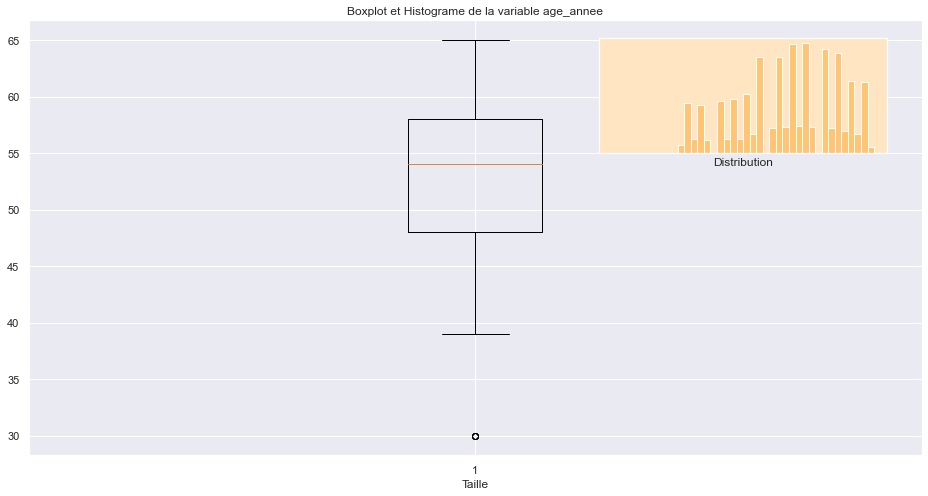

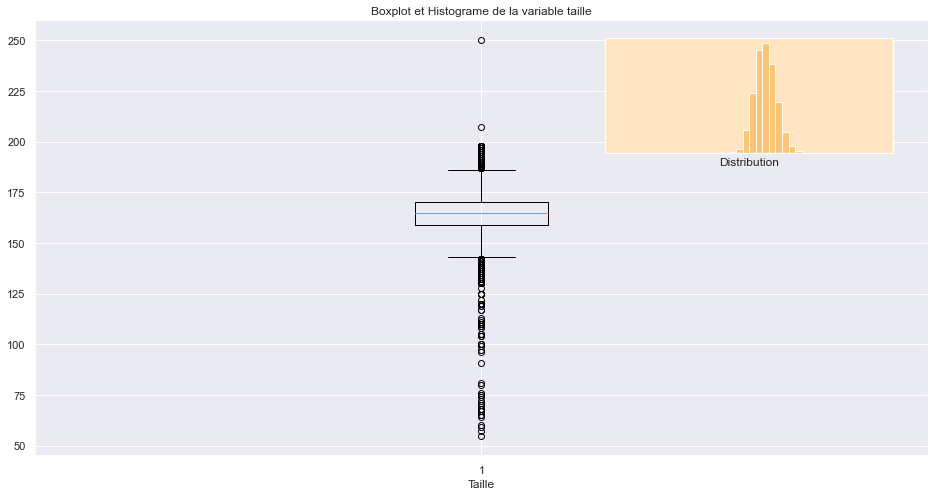

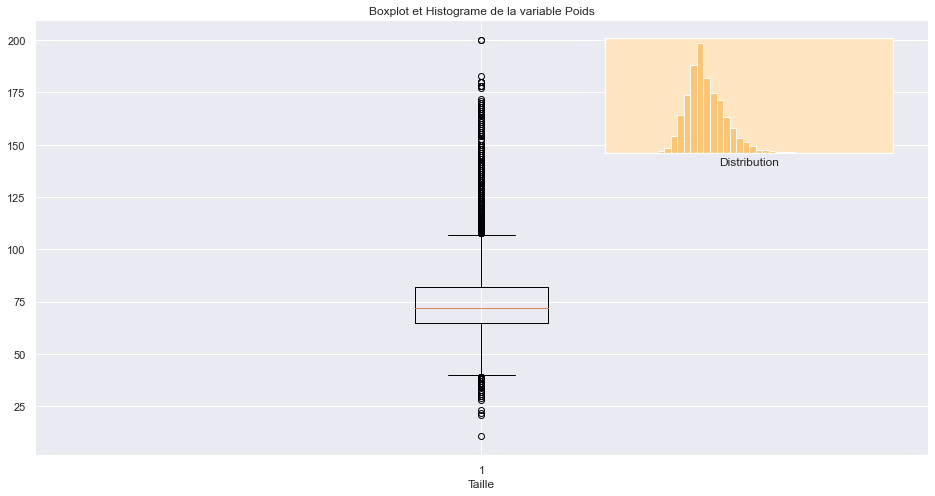

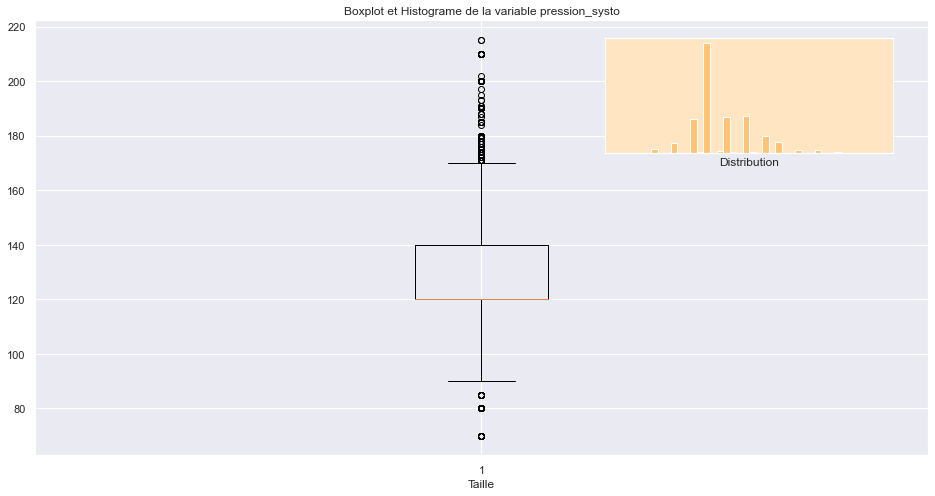

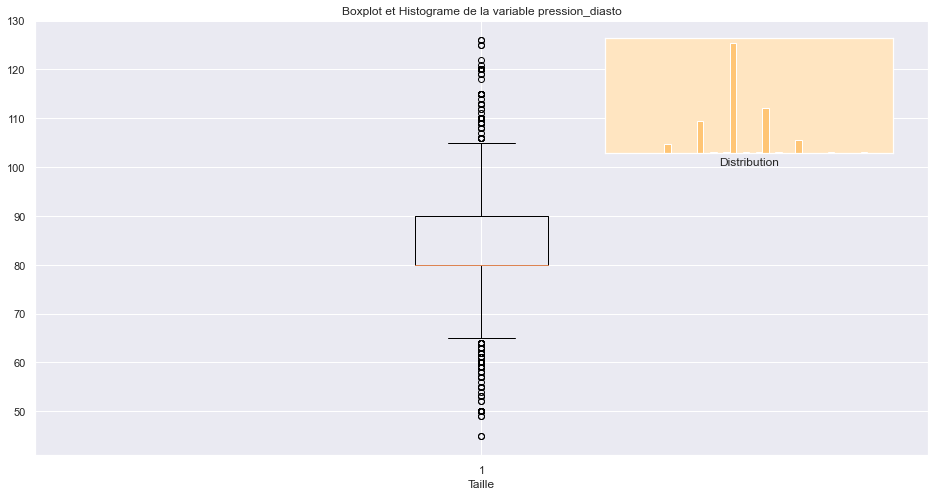

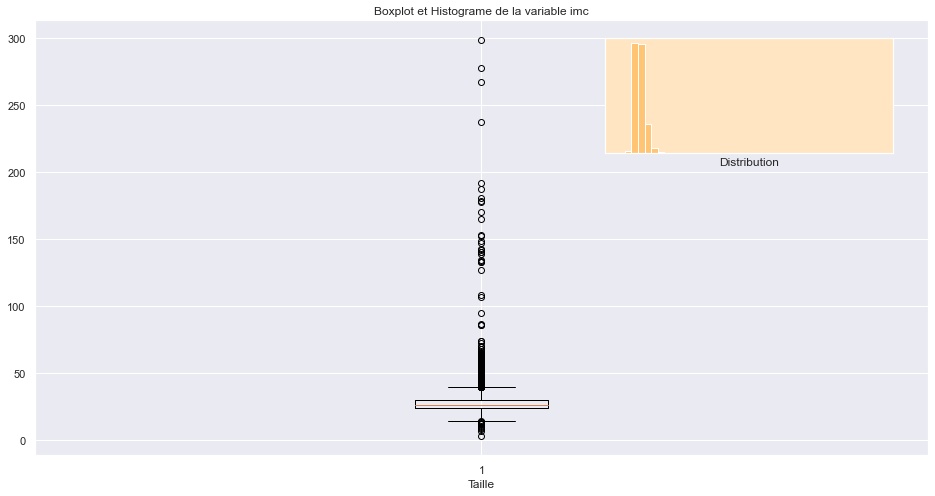

In [74]:

for i in range(0,6):
        make_box_hist(label_quant[i], df_heart)

On remarque qu’il y a des très petites variances, notamment pour l’IMC, la taille et le poids. Nous remarquons que la répartition des variables est très proche (notamment l’IMC) et en même temps très répartie. Nos individus ont tous la même tranche d’âge entre 40 ans et 65 ans, hormis un qui a 30 ans. Mais, on remarque que nos variables sur la taille et le poids rencontrent des valeurs aberrantes : en effet, on retrouve des individus de 11 kg et d’une taille de 50 cm (taille d’un nourrisson). 

Etant donné que ces valeurs aberrantes sont peu nombreuses, on décide de ne pas les retirer.


## <font color='#08AV22'>Exploration données qualitatives</font>

In [59]:
label_quali = ["genre", "cholesterol", "glycemie", "fumeur", "conso_alco", "activite_physique", "malade", "pression_arterielle", "imc_result"]

df_quali = df_heart[label_quali]

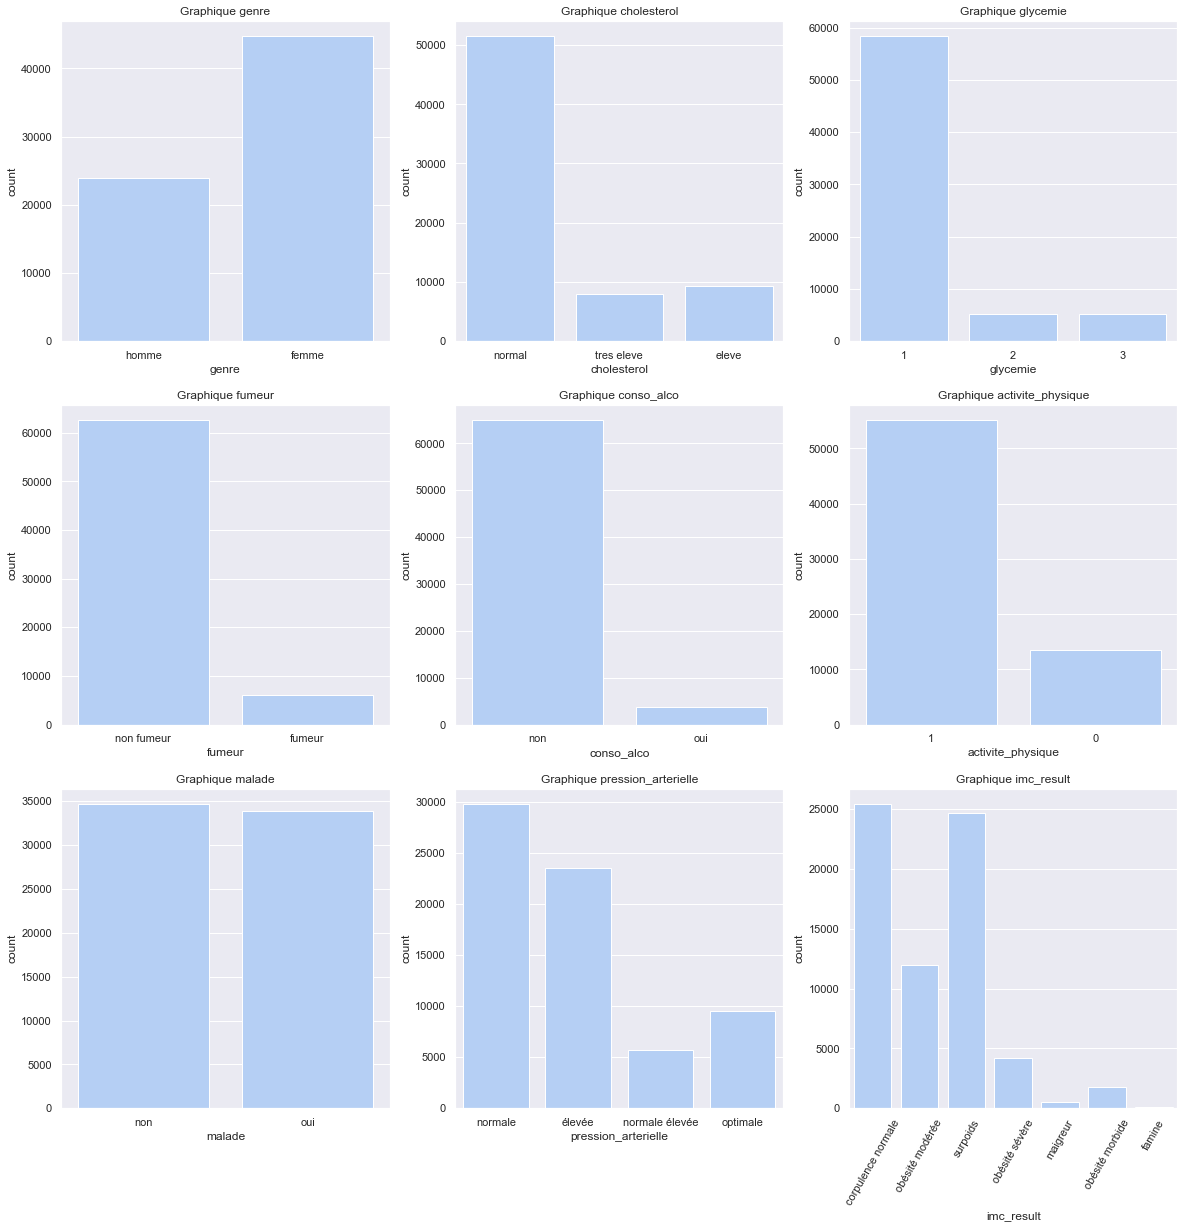

In [62]:
    
fig, axes = plt.subplots(3,3, figsize=(20,20))    


for c in range(3):
    for r in range(3):
        sns.countplot(df_quali[label_quali[r*3+c]], color="#ABCDFE",  ax = axes[r,c]).set_title("Graphique %s"% label_quali[r*3+c])
        plt.xticks(rotation=60)


On remarque que dans notre dataset, les individus :

    - sont plus de femmes que d'hommes,
    - ont un cholesterol normal,
    - ont un glycemie normal,
    - sont en majorité non fumeur,
    - ne consomment pas d'alcool,
    - font une activité physique
    - sont 50% à être atteint d'une maladie cardiaque
    - ont une pression arterielle en normale et élevée
    - ont une IMC soit avec une corpulence normale / obésitée modérée ou en surpoids
    
On peut dire qu'ils ont un mode vie sain.

## <font color='#08AV22'>Statistiques Bivariées</font>
### <font color='#ED944E'>Quanti - Quanti</font>

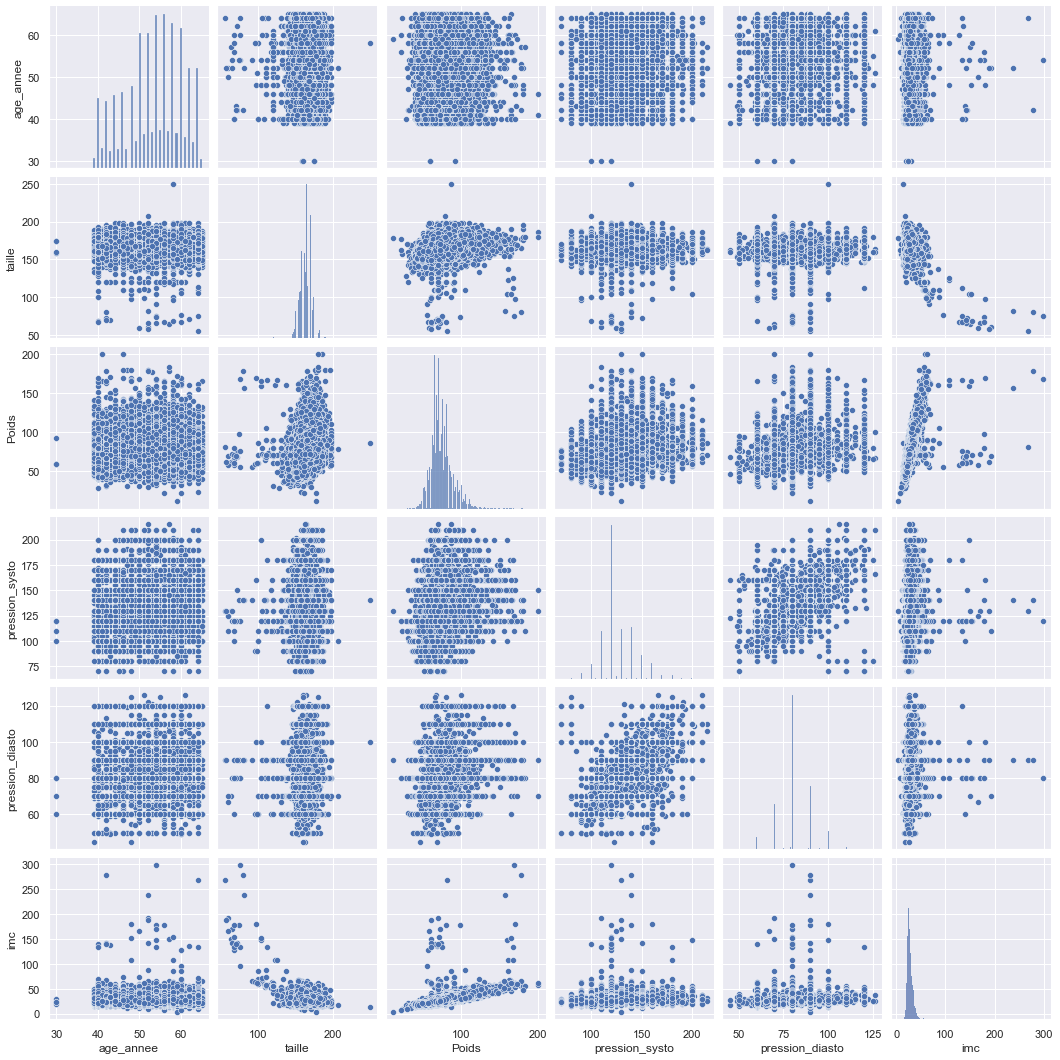

In [24]:
sns.pairplot(df_quant)

<AxesSubplot:>

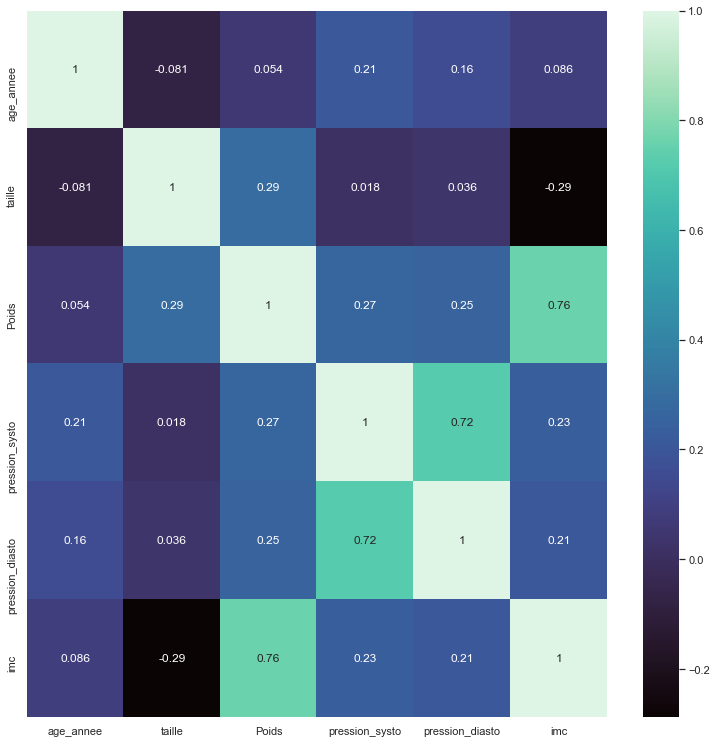

In [25]:
sns.set(rc={'figure.figsize':(13,13)})
sns.heatmap(df_quant.corr(),annot=True,cmap = "mako")

On peut voir que parmi nos variables quantitatives il y a très peu de corrélation. 

### <font color='#ED944E'>Quali - Quali</font>

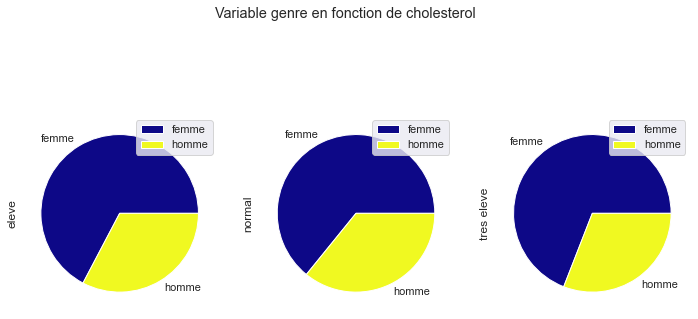

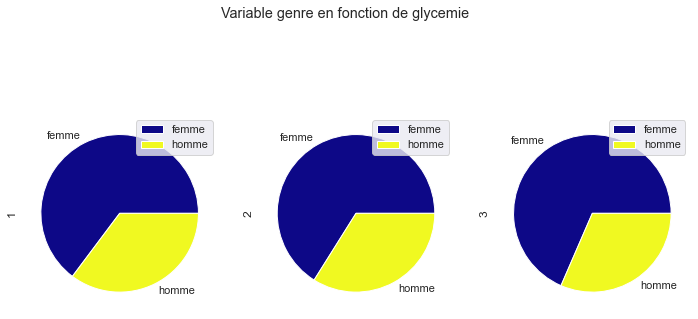

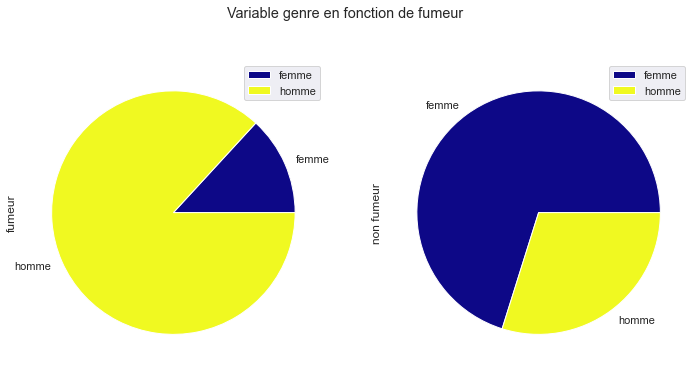

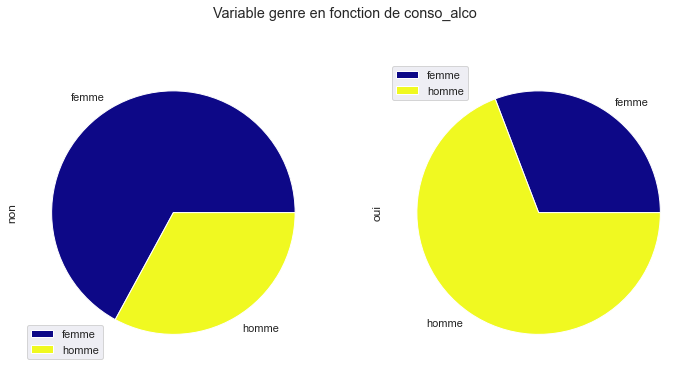

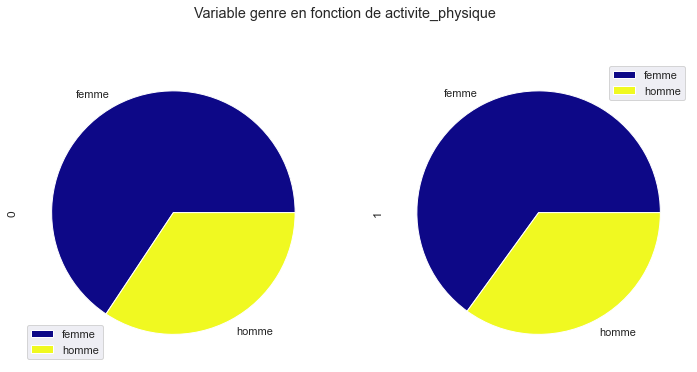

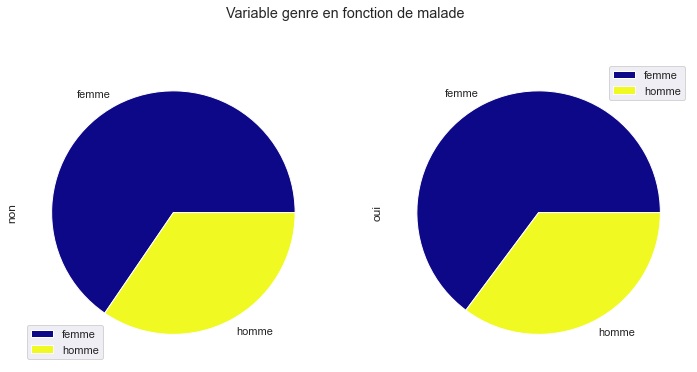

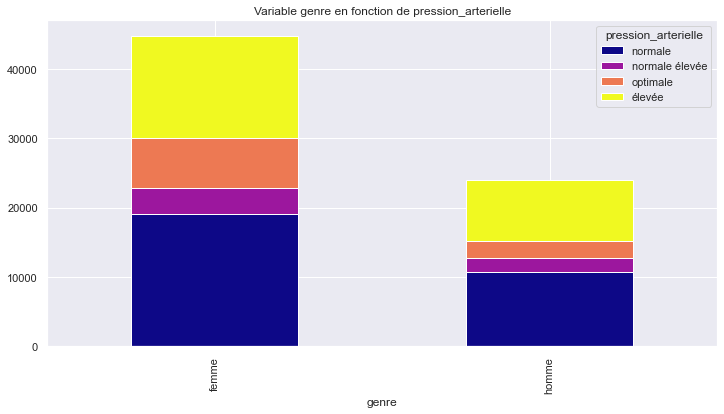

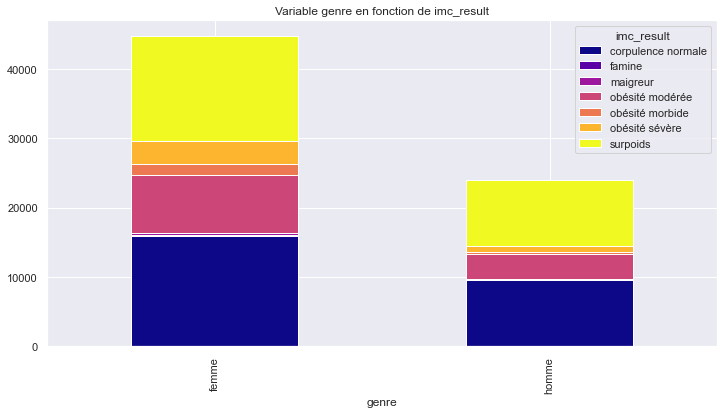

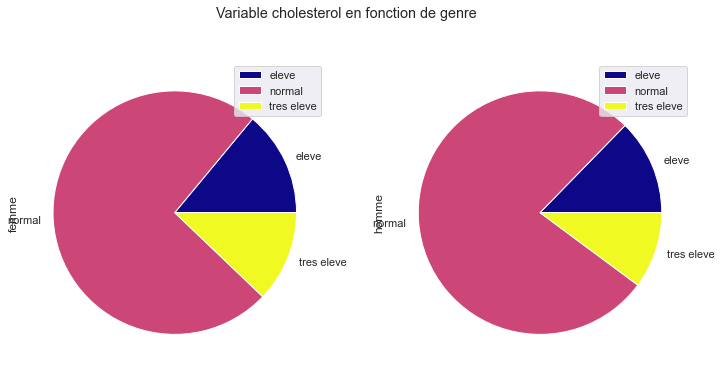

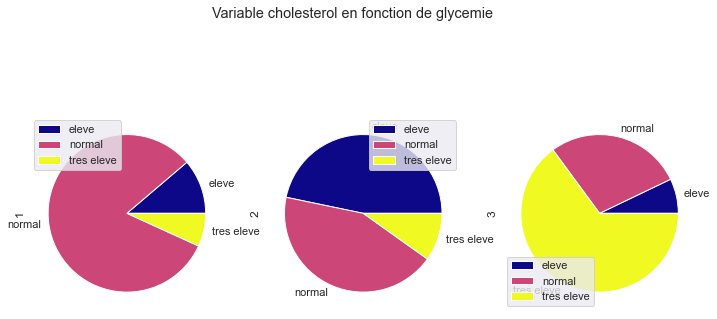

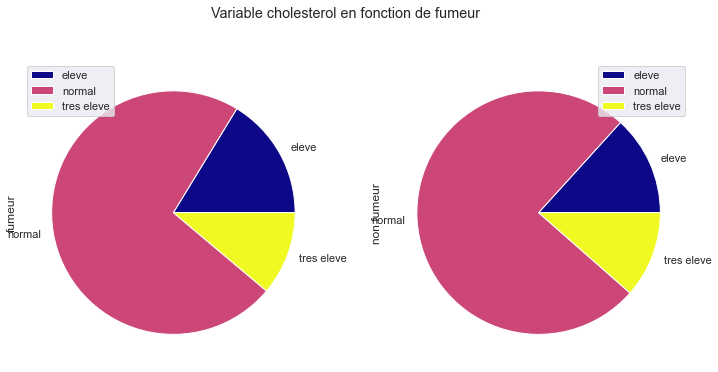

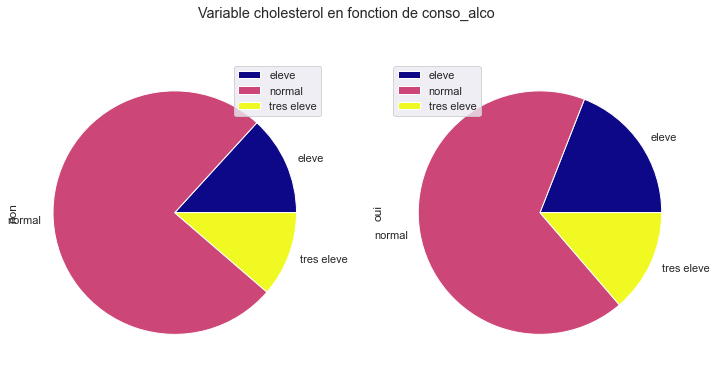

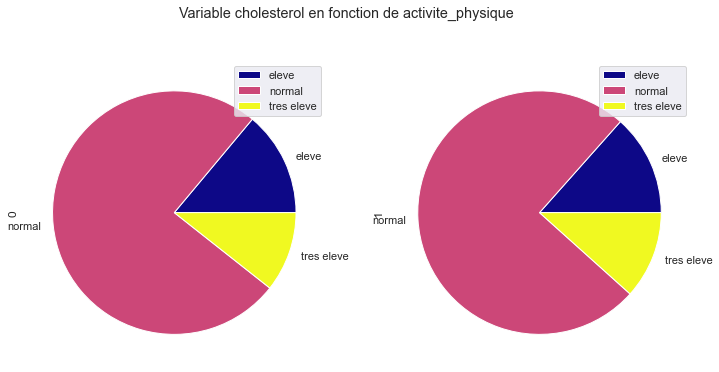

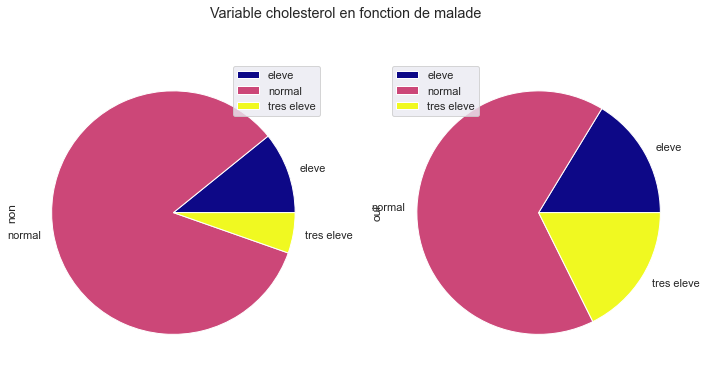

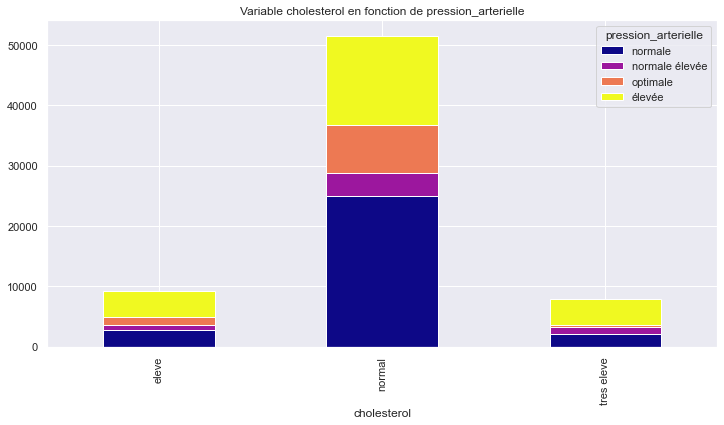

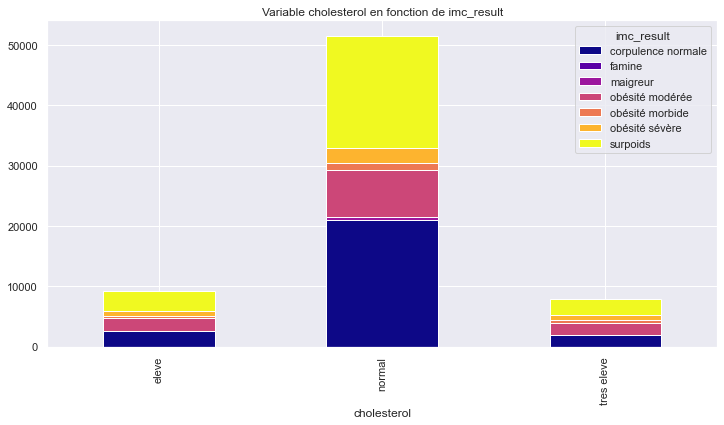

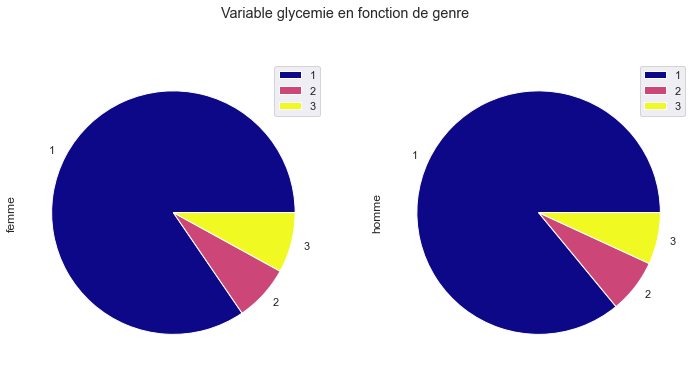

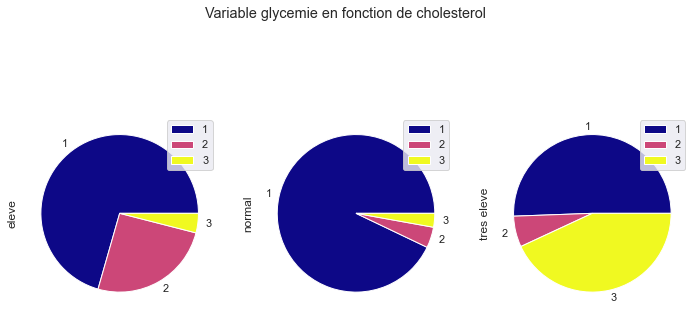

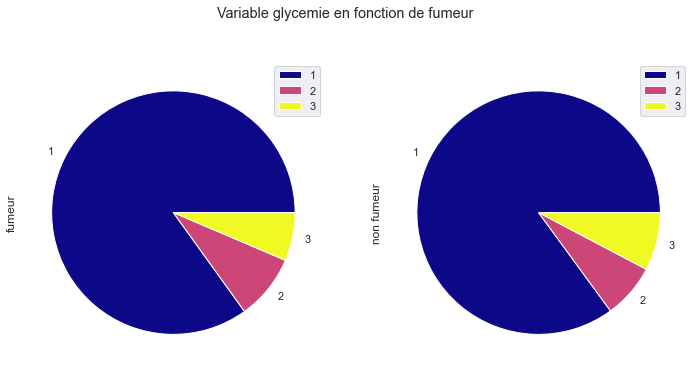

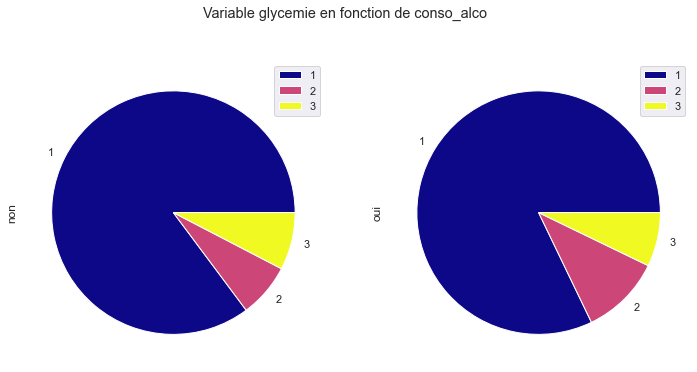

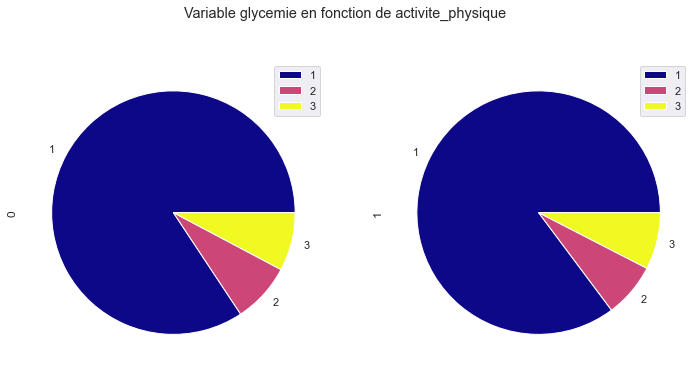

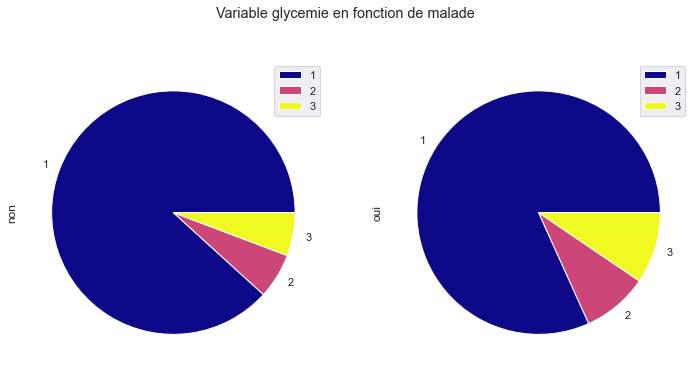

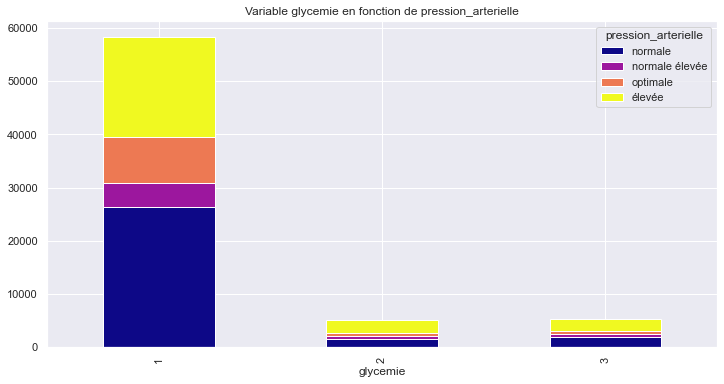

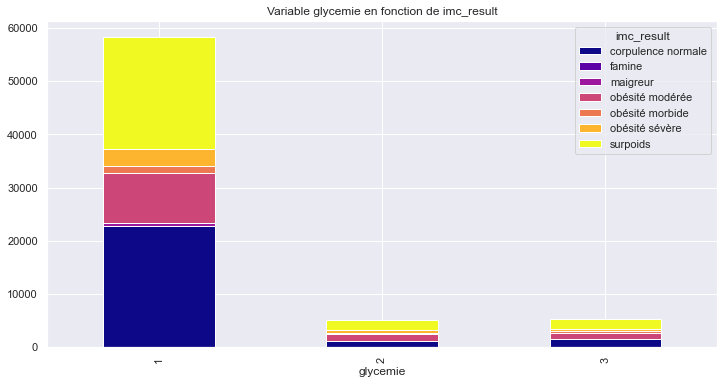

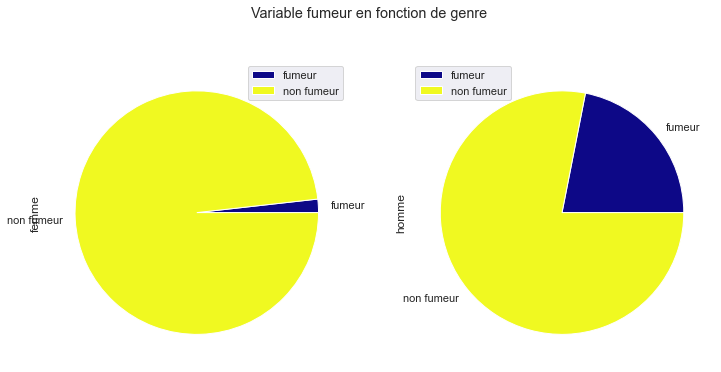

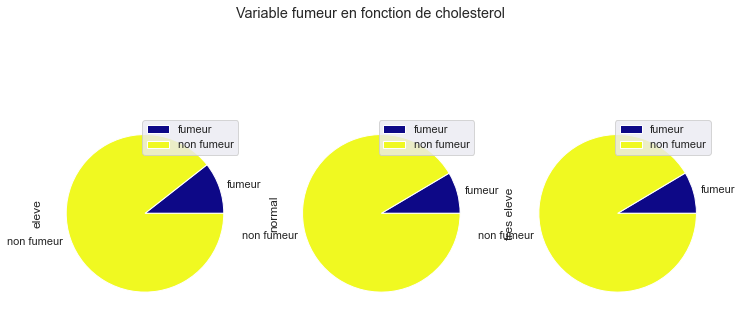

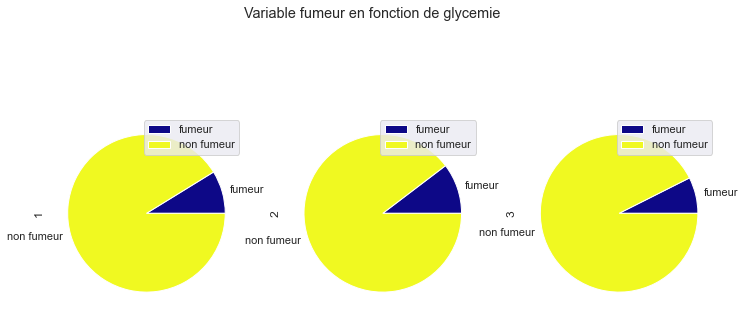

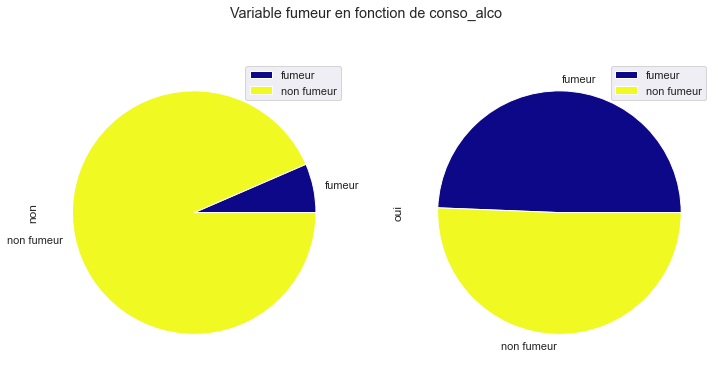

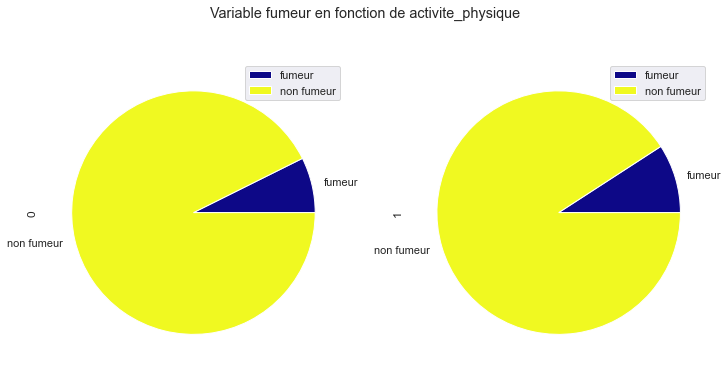

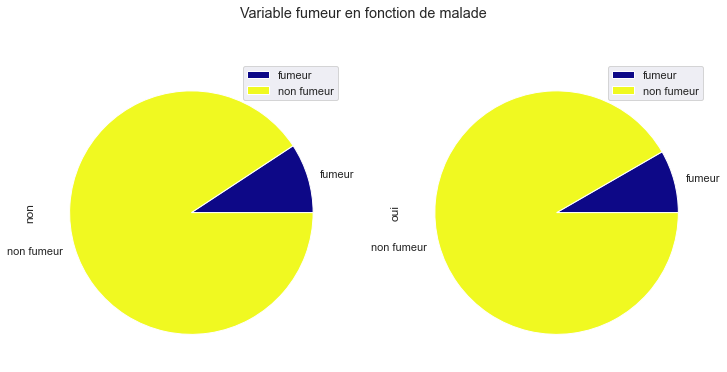

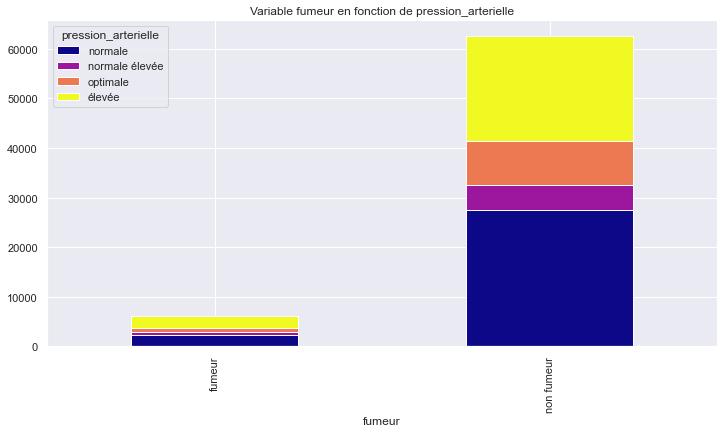

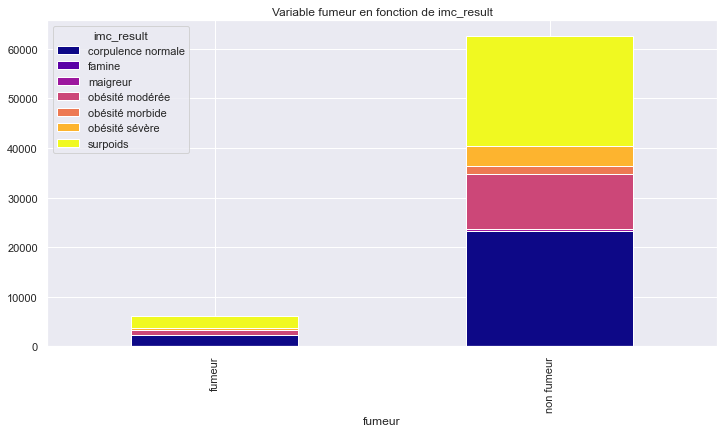

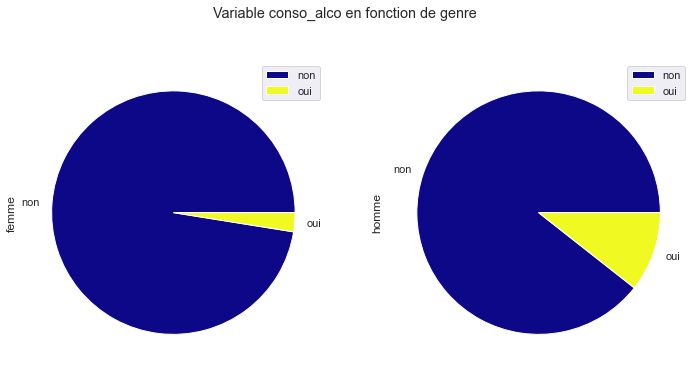

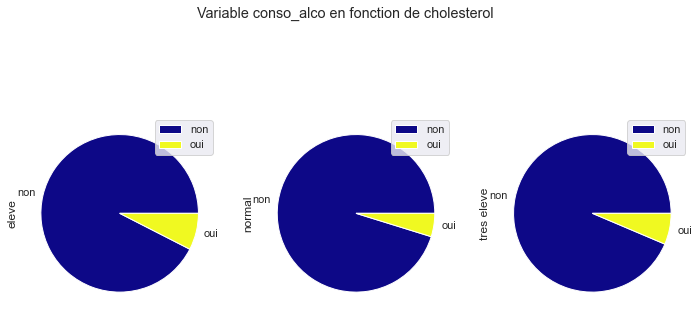

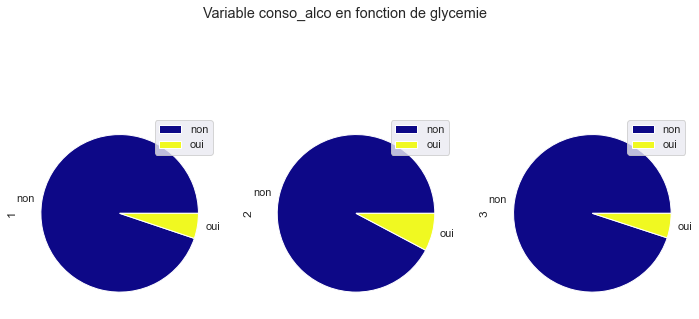

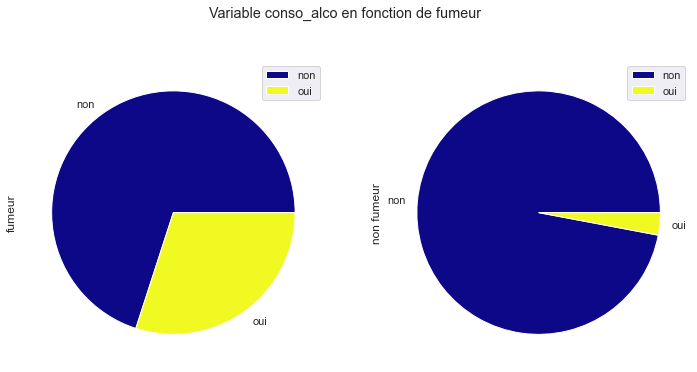

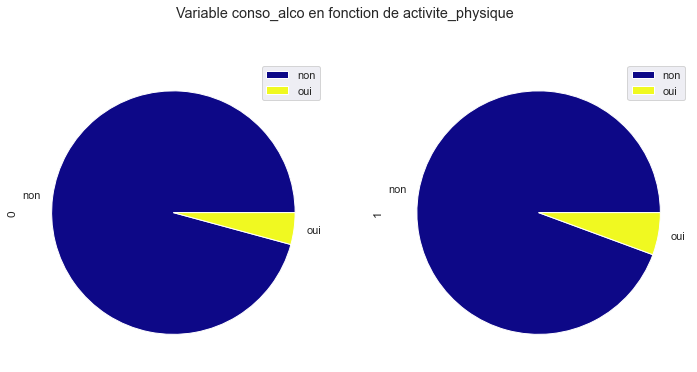

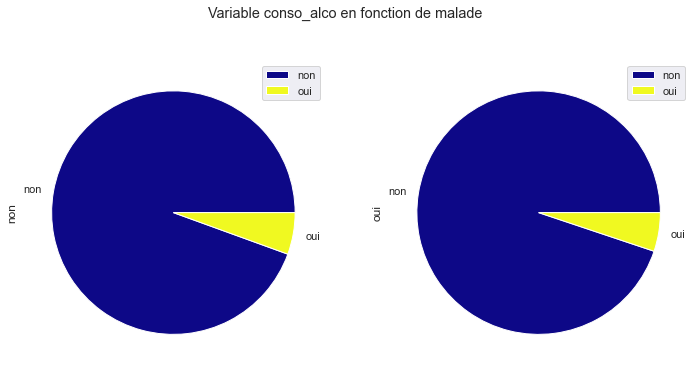

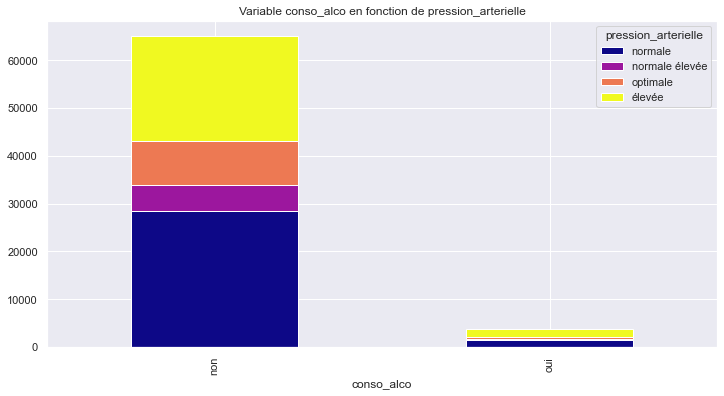

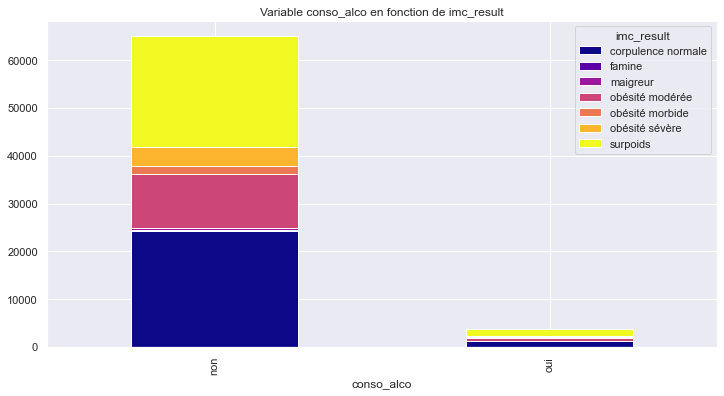

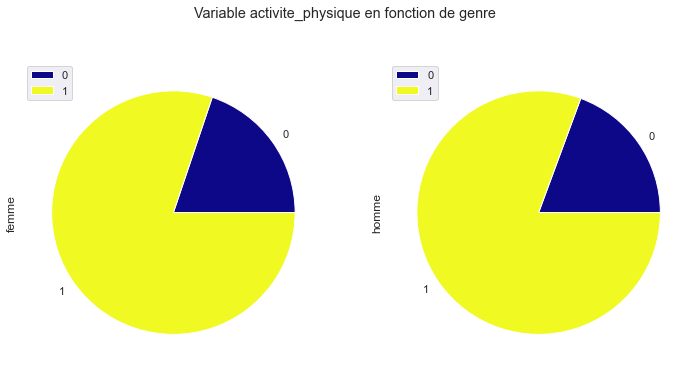

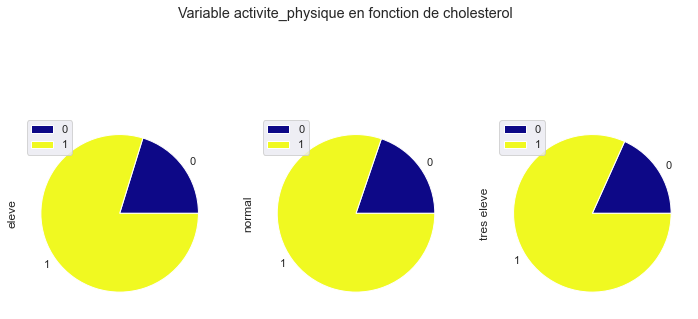

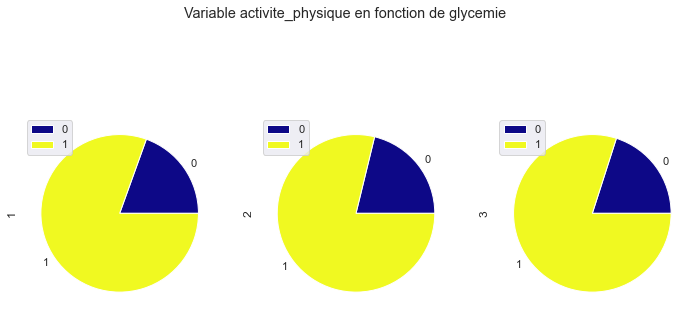

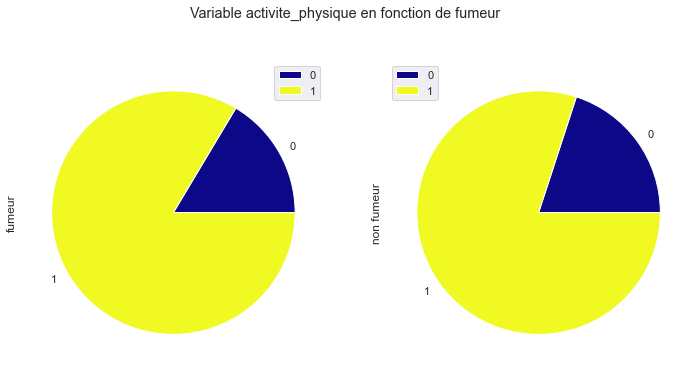

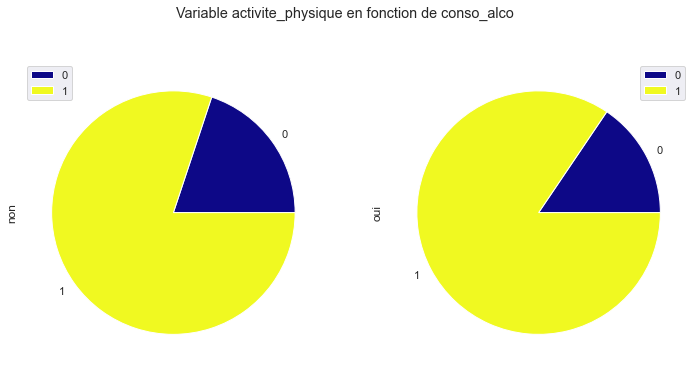

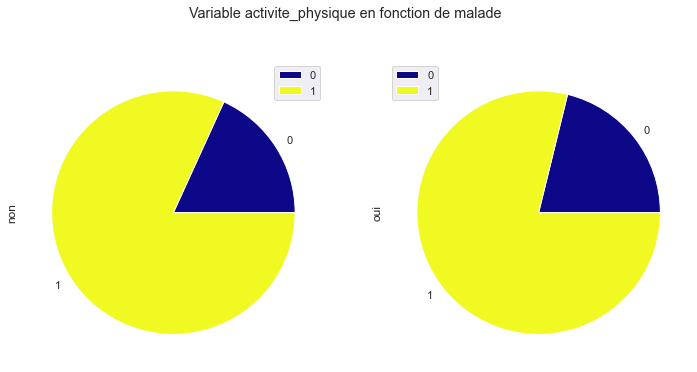

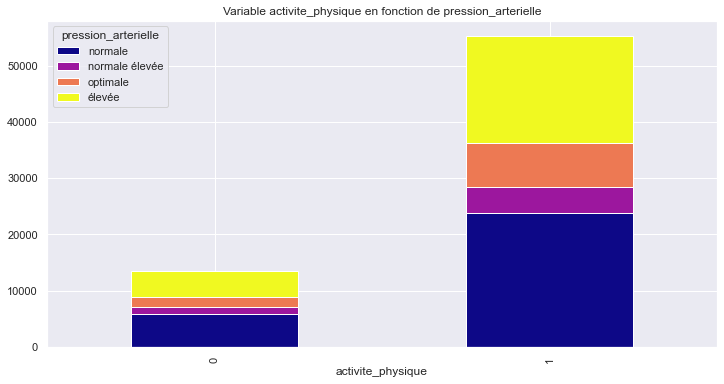

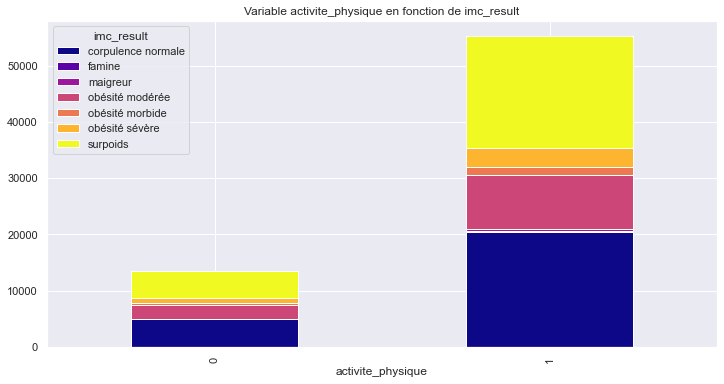

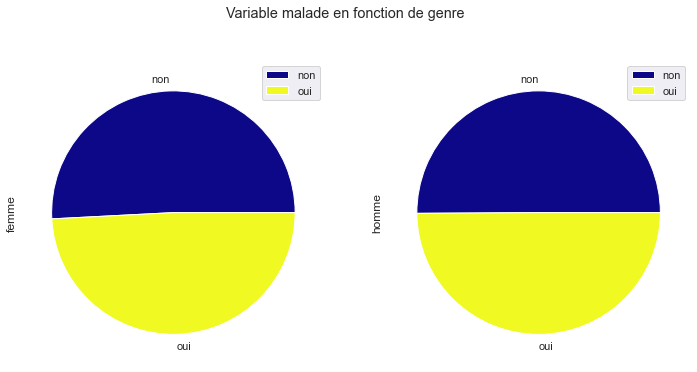

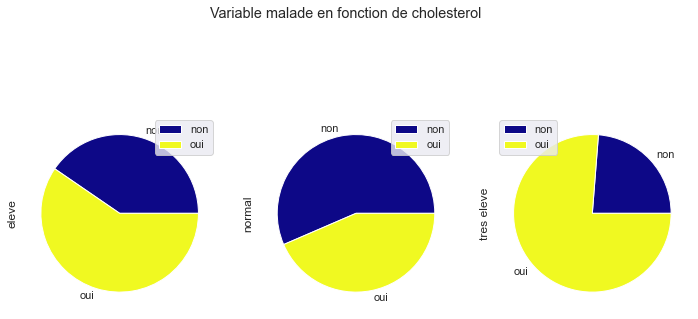

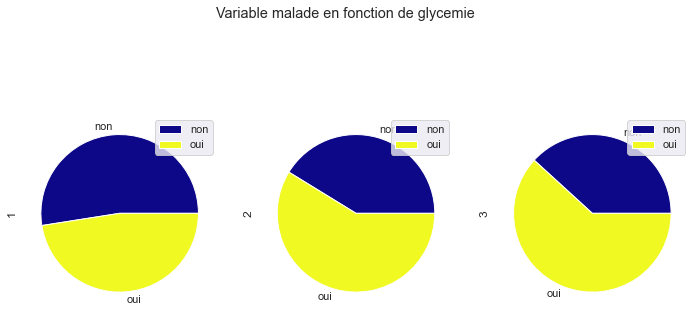

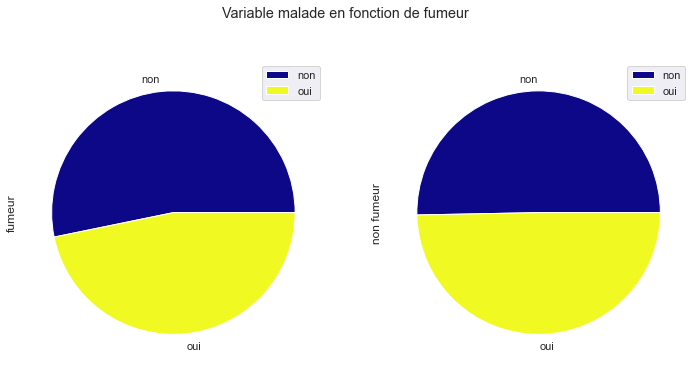

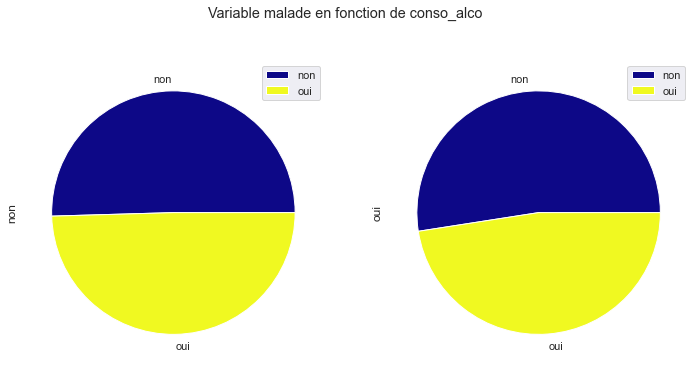

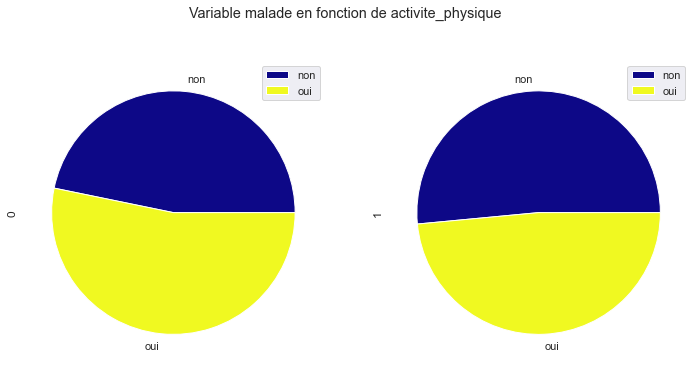

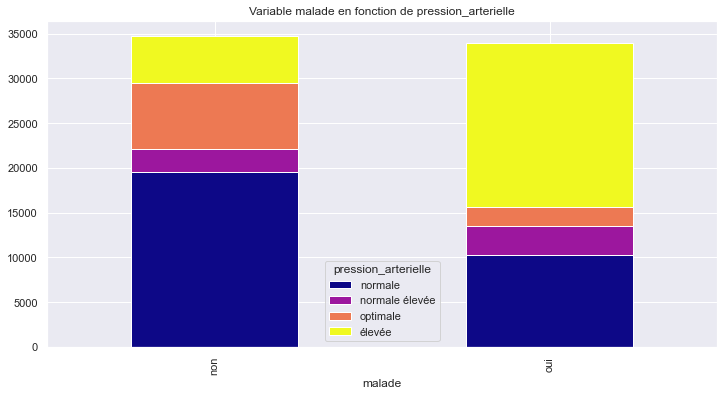

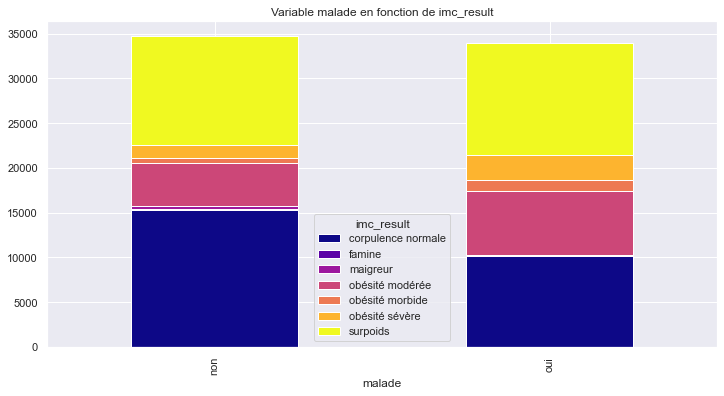

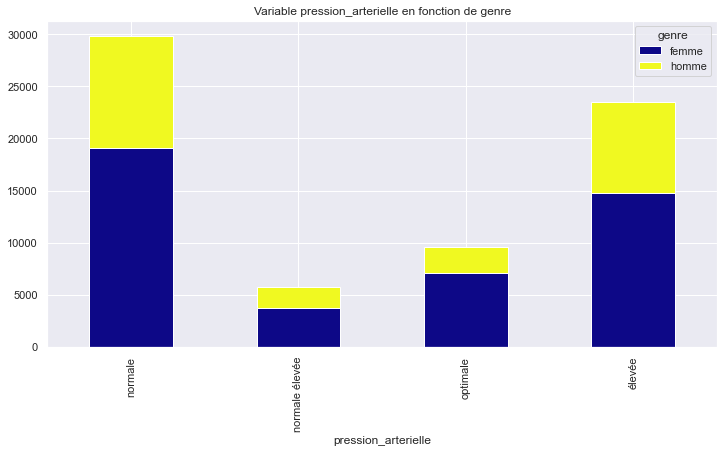

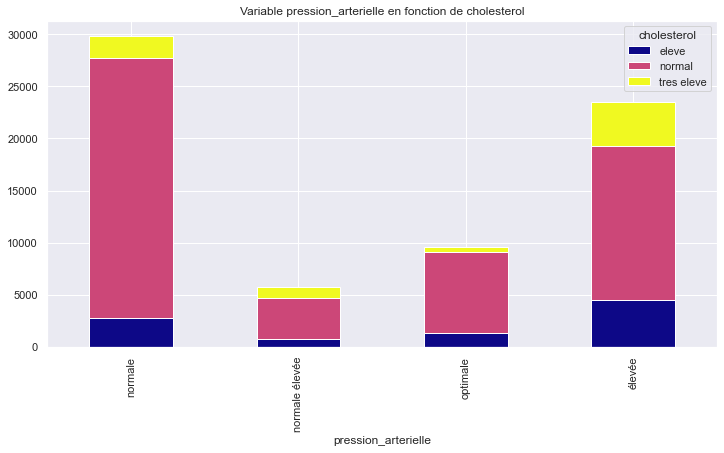

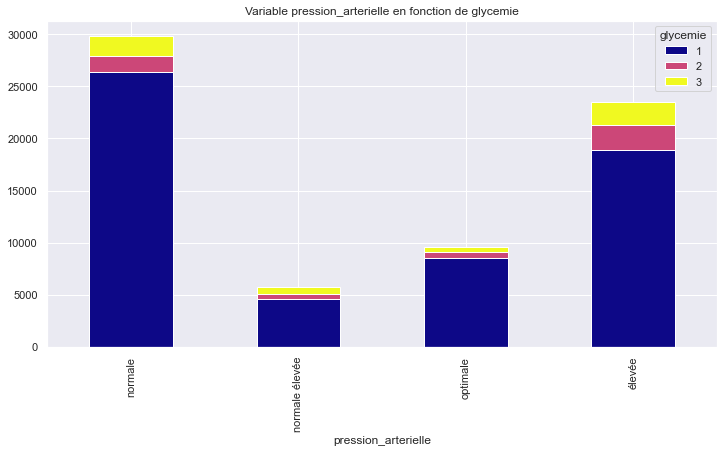

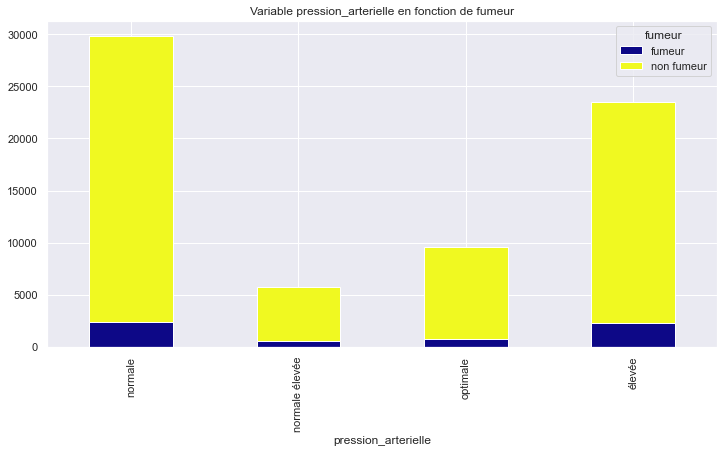

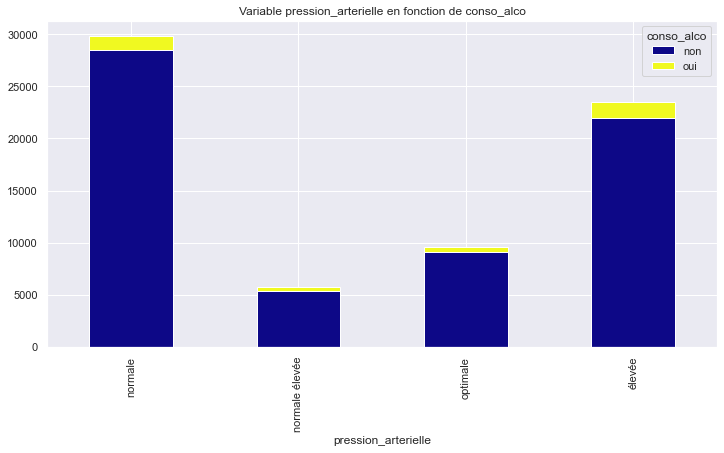

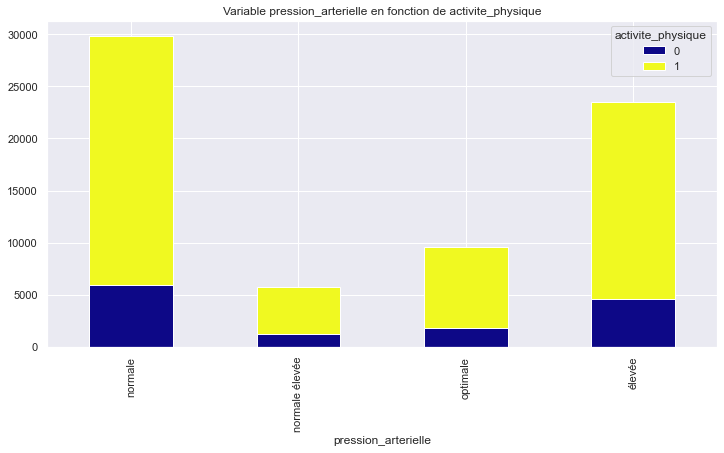

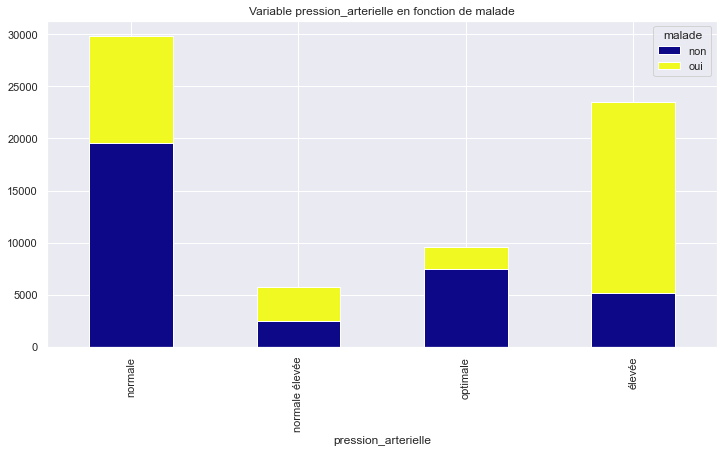

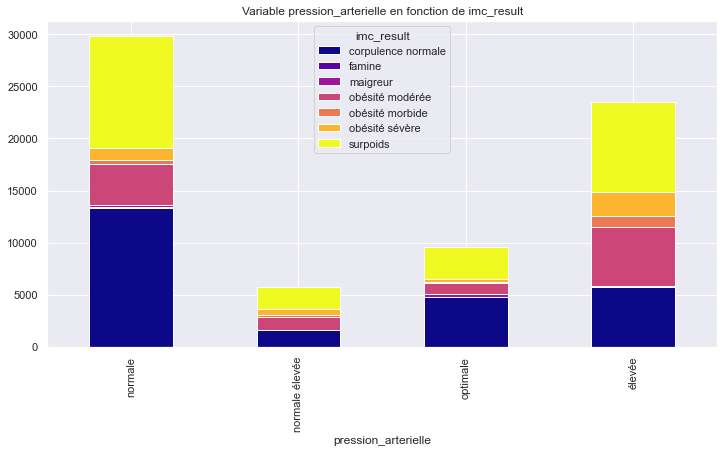

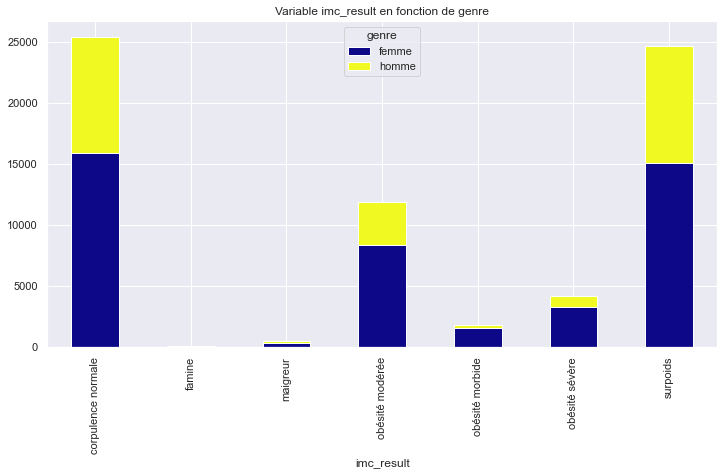

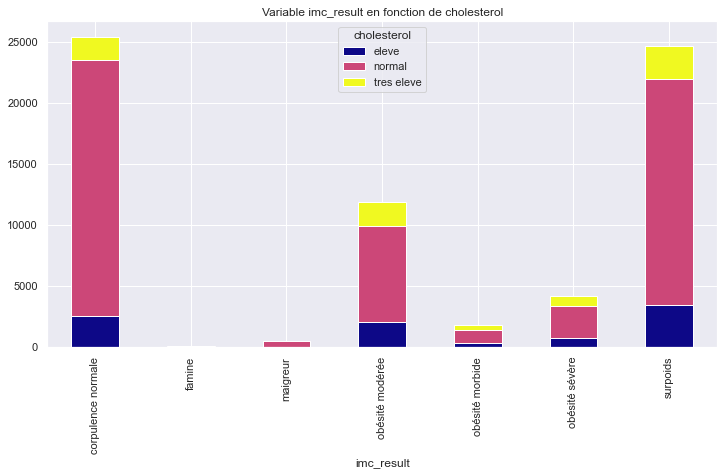

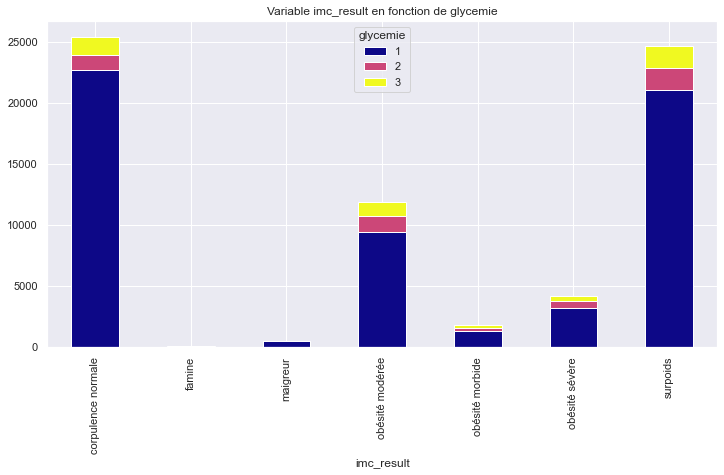

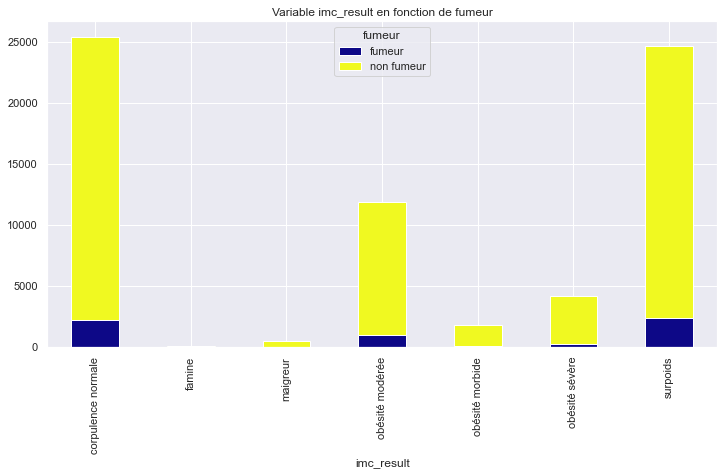

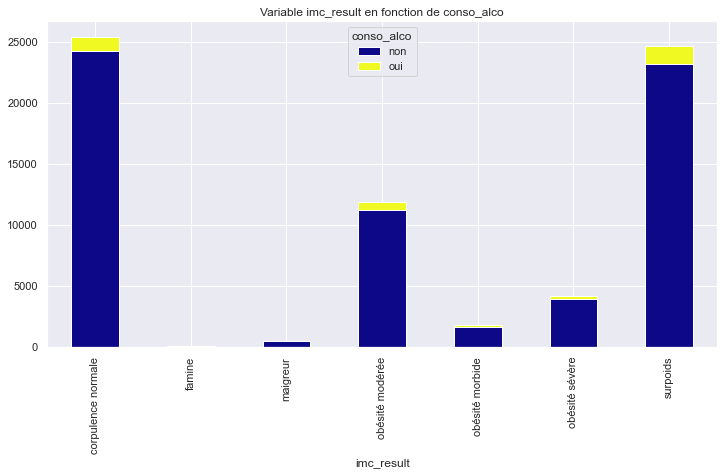

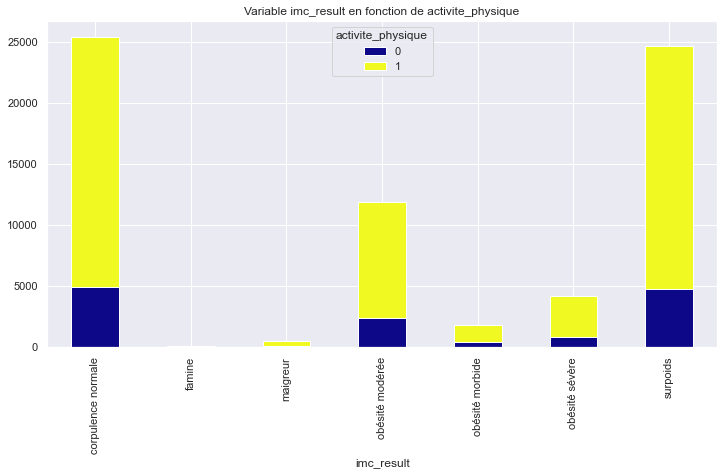

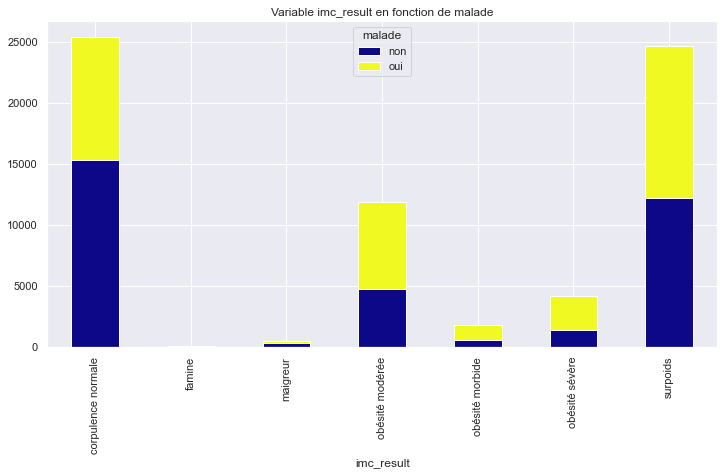

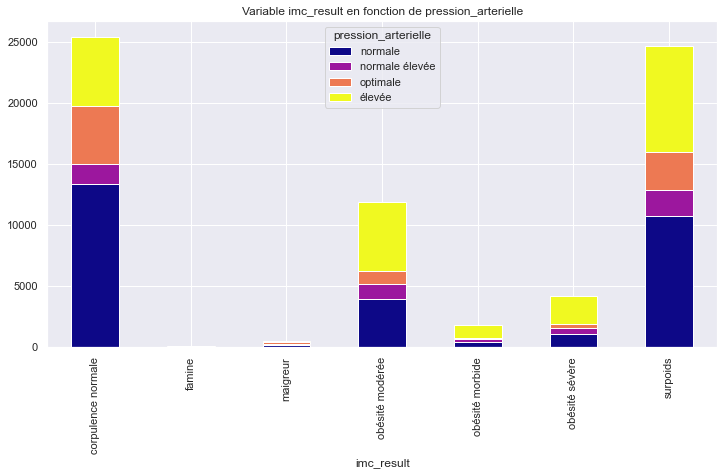

In [26]:
for i in label_quali:
    for j in label_quali:
        if i != j:
            if df_quali[j].nunique() < 4 and df_quali[i].nunique() < 4:
                t = pd.crosstab(df_quali[i], df_quali[j]) 
                t.plot.pie(subplots = True, figsize = (12, 6),cmap = 'plasma', title="Variable %s"% i + " en fonction de %s"%j)
            else : 
                t = pd.crosstab(df_quali[i], df_quali[j]) 
                t.plot.bar(stacked = True, figsize = (12, 6), cmap = 'plasma',title="Variable %s"% i + " en fonction de %s"%j)
           

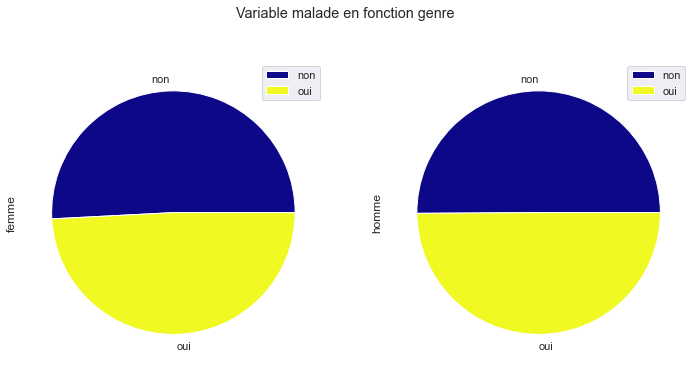

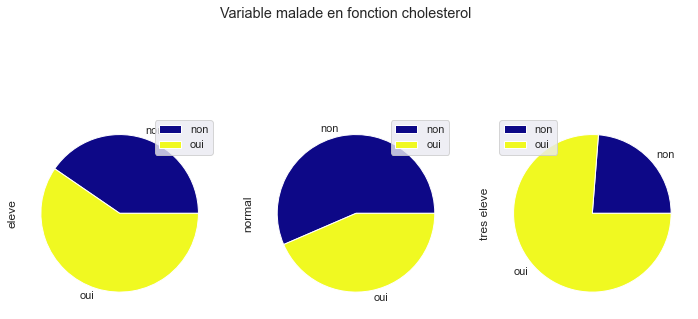

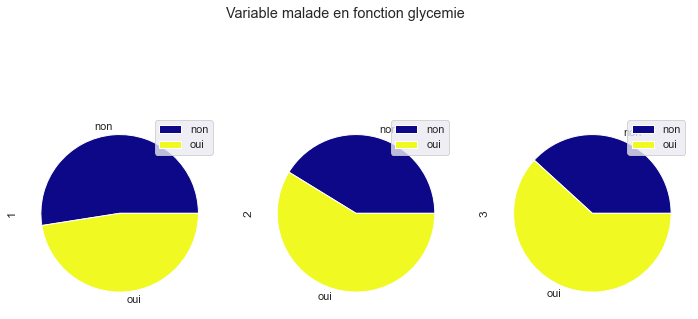

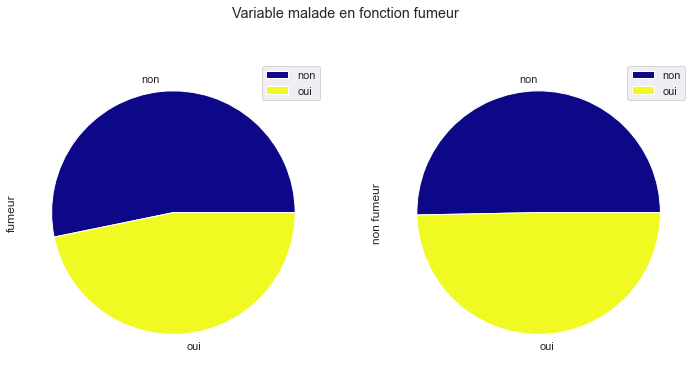

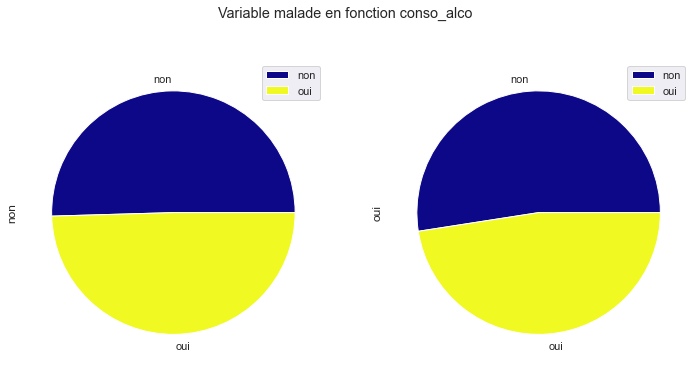

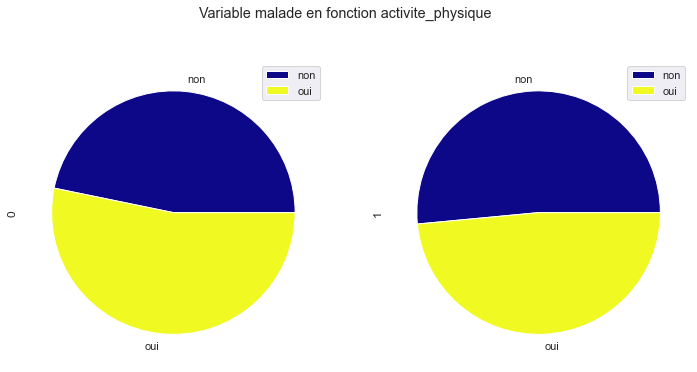

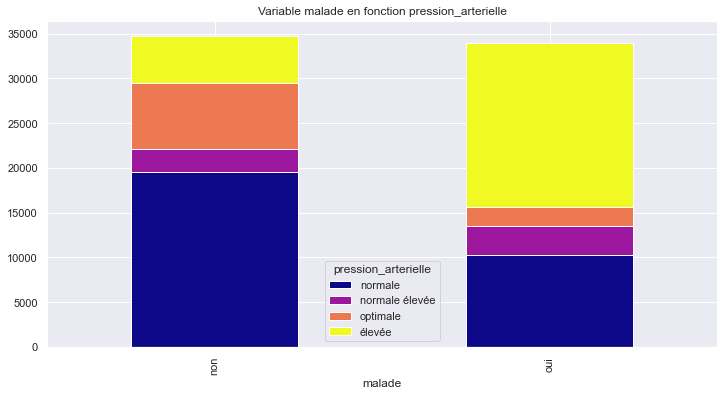

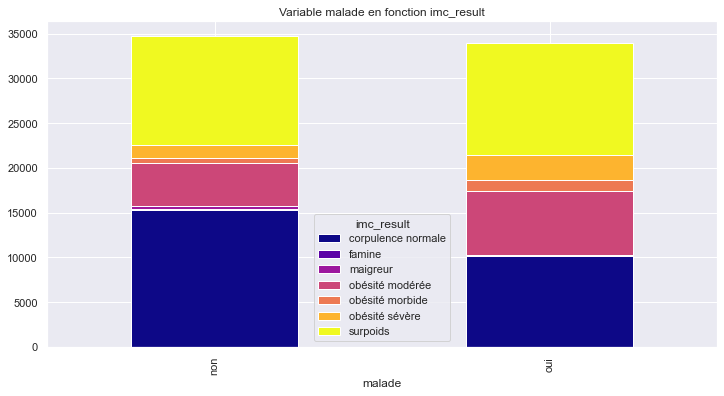

In [27]:
#Si on s'intéresse uniquement à notre variable cible : malade
for j in label_quali:
    if 'malade' != j:
        if df_quali[j].nunique() < 4:
            t = pd.crosstab(df_quali['malade'], df_quali[j]) 
            t.plot.pie(subplots = True, figsize = (12, 6), cmap = 'plasma',title="Variable malade en fonction %s"% j)
        else : 
            t = pd.crosstab(df_quali['malade'], df_quali[j]) 
            t.plot.bar(stacked = True, figsize = (12, 6),cmap = 'plasma', title="Variable malade en fonction %s"%j)

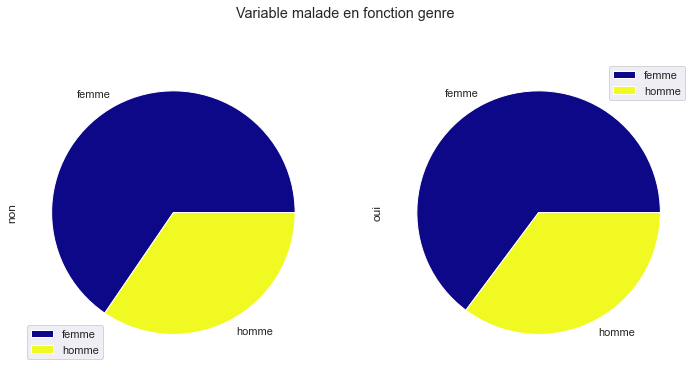

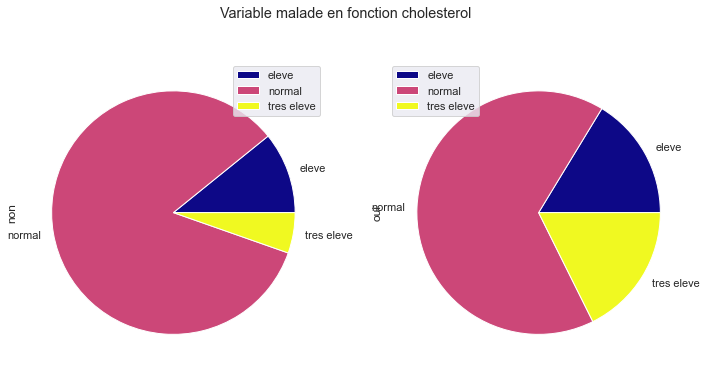

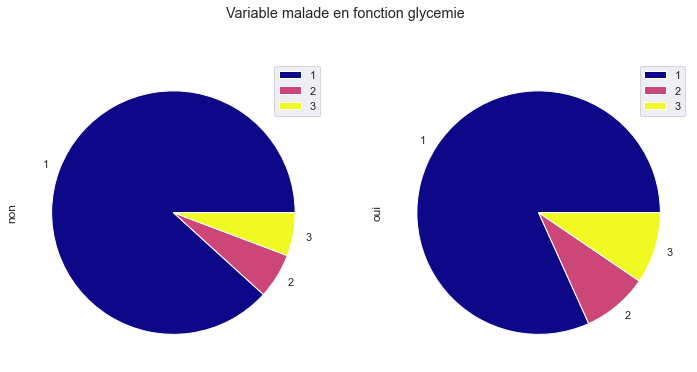

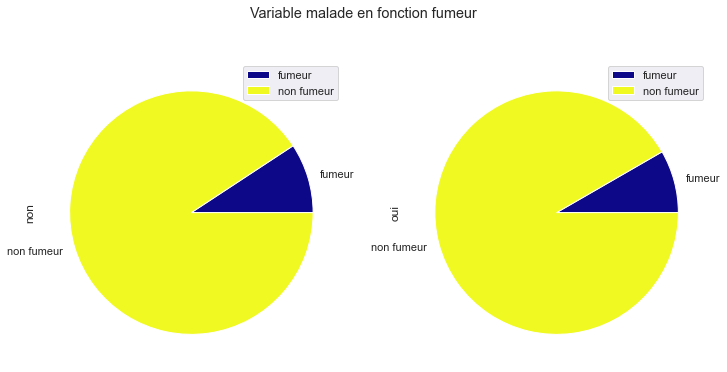

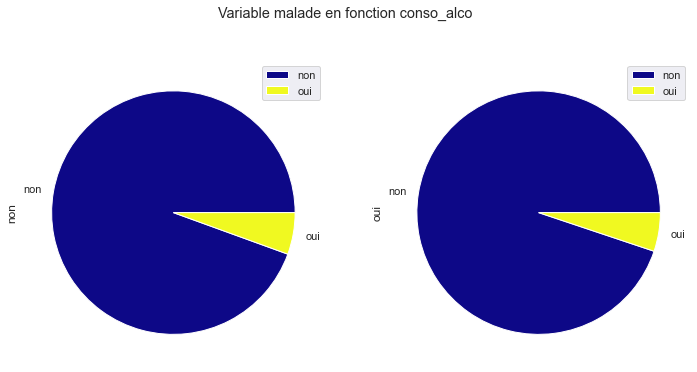

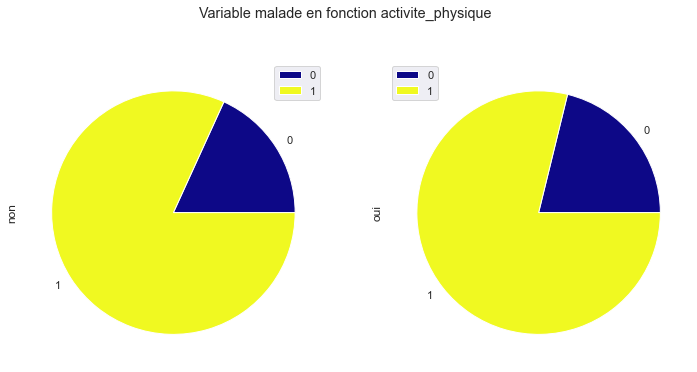

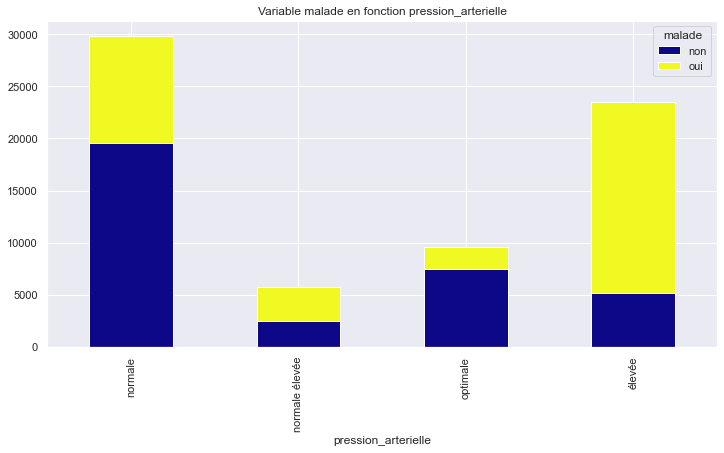

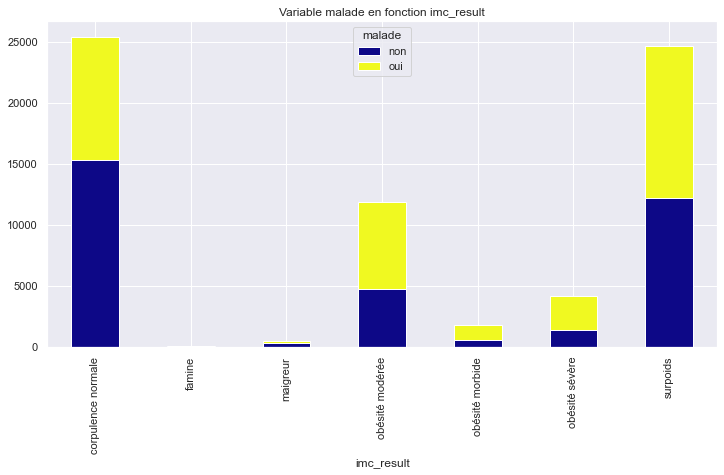

In [63]:
for j in label_quali:
    if 'malade' != j:
        if df_quali[j].nunique() < 4:
            t = pd.crosstab( df_quali[j],df_quali['malade'],) 
            t.plot.pie(subplots = True, figsize = (12, 6), cmap = 'plasma',title="Variable malade en fonction %s"% j)
        else : 
            t = pd.crosstab( df_quali[j],df_quali['malade']) 
            t.plot.bar(stacked = True, figsize = (12, 6),cmap = 'plasma', title="Variable malade en fonction %s"%j)

### <font color='#ED944E'>Quali - Quanti</font>

In [28]:
for i in label_quali:
    print("------------------------"+i+"------------------------")
    for j in label_quant: 
        print("Tableau %s"%i+"/%s"%j)
        print(df_heart.groupby(i)[j].agg([np.mean, np.std, np.median, np.min, np.max]))
        #df_heart.boxplot(column = j, by = i)
        #df_heart.hist(column = j, by = i)
        print("")

------------------------genre------------------------
Tableau genre/age_annee
            mean       std  median  amin  amax
genre                                         
femme  53.439448  6.669927      54    30    65
homme  53.108316  6.945720      54    30    65

Tableau genre/taille
             mean       std  median  amin  amax
genre                                          
femme  161.373977  7.036515     162    55   250
homme  169.944045  7.194021     170    65   207

Tableau genre/Poids
            mean        std  median  amin   amax
genre                                           
femme  72.470842  14.149894    70.0  21.0  200.0
homme  77.158441  14.121298    75.0  11.0  200.0

Tableau genre/pression_systo
             mean        std  median  amin  amax
genre                                           
femme  125.833617  16.645418     120    70   215
homme  127.950230  16.304314     120    70   210

Tableau genre/pression_diasto
            mean       std  median  amin  amax

              mean        std  median  amin  amax
malade                                           
non     119.546031  12.514359     120    70   210
oui     133.758251  17.096437     130    70   215

Tableau malade/pression_diasto
             mean       std  median  amin  amax
malade                                         
non     78.149758  8.160966      80    45   126
oui     84.516914  9.397008      80    45   126

Tableau malade/imc
             mean       std     median      amin        amax
malade                                                      
non     26.536313  5.567738  25.469828  7.022248  237.768633
oui     28.519160  6.345038  27.434842  3.471784  298.666667

------------------------pression_arterielle------------------------
Tableau pression_arterielle/age_annee
                          mean       std  median  amin  amax
pression_arterielle                                         
normale              52.758148  6.712490      54    30    65
normale élevée       5

(je n'ai rien remarqué particulier à commenter hormis les trucs logiques par rapport aux variables créées à partir des autres, tout est assez bien répartie ?)

Notre variable cible est la variable **malade**, donc on s'intéresse à celle-ci : 

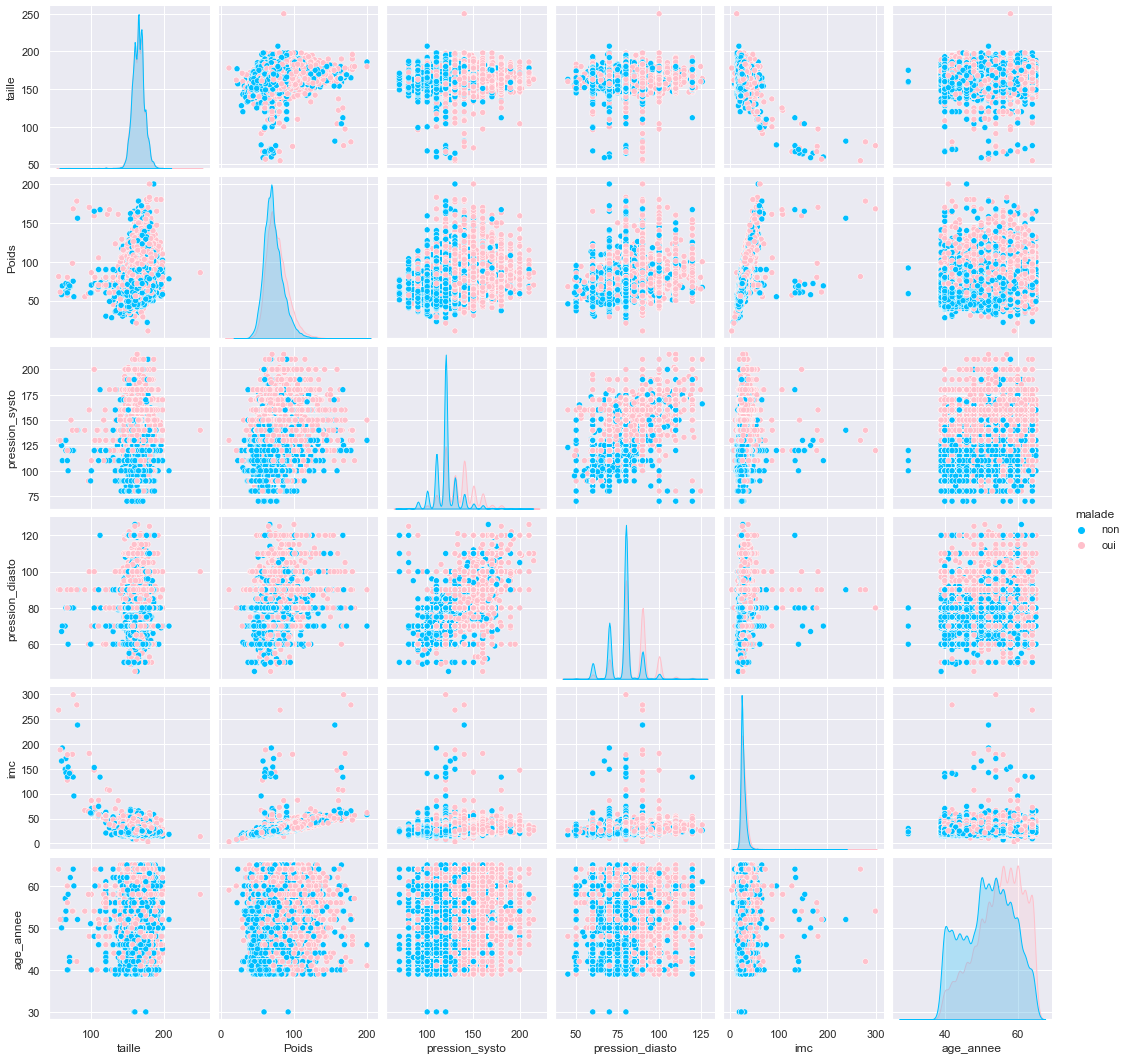

In [36]:
sns.set(rc={'figure.figsize':(6,6)})
#df_heart= df_heart.drop(['age'], axis = 1)
sns.pairplot(df_heart, hue="malade",palette = ['deepskyblue',"pink"])

On observe que la répartition des malades est homogène, qu'il n'y peu de corrélation entre les variables. On peut tout de même remarquer que les individus qui sont atteint d'une maladie cardiaque, sont plus âgés.

On remarque bien les deux groupes distincts : les individus ayant une maladie cardiaque et les individus qui ne sont pas malade. 